# Машинне навчання
# Лабораторна робота №7
# Вишотравка Діана СА-33
## Варіант 4

In [ ]:
!pip install category-encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 2.4 MB/s eta 0:00:00


In [ ]:
!pip install kneed

In [ ]:
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 100.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import re
import itertools
from tqdm import tqdm
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as sp
from scipy.stats import uniform
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from category_encoders import CountEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, FunctionTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.manifold import  LocallyLinearEmbedding,  SpectralEmbedding
from sklearn_pandas import DataFrameMapper, gen_features
from matplotlib import cm
from sklearn.metrics import calinski_harabasz_score, silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
import plotly.express as px
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from eds import *


import warnings
warnings.filterwarnings('ignore')

sns.set_theme(rc={'figure.figsize': (20 , 15 ),
                  "lines.linewidth": 2.5}, font_scale=1.5)
palette = ['#2f6142','#69e0ab', '#80e0dc', '#0ca69f', '#046091', '#877ff0', '#6a4280', '#f5a6e1', '#7a1160']
sns.set_palette(palette)

In [ ]:
class RadianTransform:
    def __init__(self):
        pass

    def fit_transform(self, data):
        radians_data = np.radians(data)
        return radians_data

    def transform(self, data):
        radians_data = np.radians(data)
        return radians_data

In [ ]:
class MonthTransform:
    def __init__(self):
        pass

    def fit(self, data):
      return self

    def fit_transform(self, data):
      angle = 2.0 * np.pi * (data - 1) / 12
      return np.sin(angle)

    def transform(self, data):
        angle = 2.0 * np.pi * (data - 1) / 12
        return np.sin(angle)

In [ ]:
def plot_dbscan(X, model):
  labels = model.fit_predict(X.values)

  pca = PCA(n_components=2)
  pca_result = pca.fit_transform(X)
  pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

  fig, axes = plt.subplots(figsize=(8, 6))

  labels_1 = model.fit_predict(X.values)

  sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=labels_1, palette='colorblind', legend='full', alpha=0.7, ax=axes)
  outliers_mask = labels_1 == -1
  sns.scatterplot(x=pca_df[outliers_mask]['PC1'], y=pca_df[outliers_mask]['PC2'], color='black', marker='+', label='Outliers', ax=axes)


  axes.set_title('DBSCAN Clustering')
  axes.set_xlabel('Longitude')
  axes.set_ylabel('Latitude')
  plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 6)
  plt.show()

In [ ]:
def calculate_cluster_scores(X, labels, name):
    silhouette_avg = silhouette_score(X, labels)
    calinski_score = calinski_harabasz_score(X, labels)
    df = pd.DataFrame({
        'Model': [name],
        'Silhouette Score': [silhouette_avg],
        'Calinski-Harabasz Score': [calinski_score]
    })
    return df

In [ ]:
def plot_clusters(X, model, clusters, silh):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)
    pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

    fig, axes = plt.subplots(figsize=(8, 6))
    labels_1 = model.predict(X)

    sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=labels_1, palette='colorblind', legend='full', alpha=0.7, ax=axes)

    centroids = pca.transform(model.cluster_centers_)
    sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='+', s=100, c='black', label='centroids', ax=axes)

    axes.set_title(f'{clusters}-means Clustering, Silhouette Coefficient: {round(silh, 3)}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def visualize(df, **kwargs):
    columns = df.columns
    num_rows = (len(columns))
    fig, axes = plt.subplots(nrows=num_rows, figsize=(20, num_rows * 5))
    for i, column in enumerate(columns):
        row = i
        sns.countplot(df, x =column, hue= column, ax=axes[row])
        for k in range(len(axes[row].containers)):
            axes[row].bar_label(axes[row].containers[k], fontsize=17)
    fig.tight_layout()
    return fig, axes

In [ ]:
def remove_bracket_content(text):
    if isinstance(text, str):
        return re.sub(r'\s*\([^)]*\)', '', text)
    else:
        return text

In [ ]:
def seiche(text):

    if re.search(r'\bseiche\b', text):
        return "Seiche"
    else:
        return text

In [ ]:
def undef(text):
    if 'undef' in text:
        return "undef"
    else:
        return text

In [ ]:
def short_name(df):
    df['DAMAGE_TOTAL_DESCRIPTION'] = df['DAMAGE_TOTAL_DESCRIPTION'].apply(remove_bracket_content).fillna('undefined')
    df['HOUSES_TOTAL_DESCRIPTION'] = df['HOUSES_TOTAL_DESCRIPTION'].apply(remove_bracket_content)
    df['DEATHS_TOTAL_DESCRIPTION'] = df['DEATHS_TOTAL_DESCRIPTION'].apply(remove_bracket_content)
    return df

In [ ]:
class ChangeColl(BaseEstimator, TransformerMixin):
    def init(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return short_name(X)
short = Pipeline([
    ('change_colls', ChangeColl())
])

In [ ]:
def combine_values(row):
    if row['DAMAGE_TOTAL_DESCRIPTION'] == 'undef' and row['DEATHS_TOTAL_DESCRIPTION'] != 'undef':
        return row['DEATHS_TOTAL_DESCRIPTION'] + '_deaths'
    elif row['DAMAGE_TOTAL_DESCRIPTION'] == 'undef' and row['DEATHS_TOTAL_DESCRIPTION'] == 'undef':
        return row['HOUSES_TOTAL_DESCRIPTION'] + '_house'
    else:
        return row['DAMAGE_TOTAL_DESCRIPTION'] + '_damage'

In [ ]:
df = pd.read_csv('tsunami_dataset.csv')

### EDA

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2259 entries, 0 to 2258
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        2259 non-null   int64  
 1   YEAR                      2259 non-null   int64  
 2   MONTH                     2155 non-null   float64
 3   DAY                       2082 non-null   float64
 4   HOUR                      1308 non-null   float64
 5   MINUTE                    1235 non-null   float64
 6   LATITUDE                  2259 non-null   float64
 7   LONGITUDE                 2259 non-null   float64
 8   LOCATION_NAME             2250 non-null   object 
 9   COUNTRY                   2259 non-null   object 
 10  REGION                    2258 non-null   object 
 11  CAUSE                     2258 non-null   object 
 12  EVENT_VALIDITY            2259 non-null   object 
 13  EQ_MAGNITUDE              1474 non-null   float64
 14  EQ_DEPTH

In [ ]:
print(f'Number of duplicate entries: {df.duplicated().sum()}')
print(f'Number missing: {sum(df.isna().sum())}')

Number of duplicate entries: 0
Number missing: 10168


In [ ]:
radian_transformer = RadianTransform()
transformed_coordinate = radian_transformer.fit_transform([40])
print("Transformed Coordinate:", transformed_coordinate)

Transformed Coordinate: [0.6981317]


In [ ]:
df.nunique()

ID                          2259
YEAR                         513
MONTH                         12
DAY                           31
HOUR                          24
MINUTE                        60
LATITUDE                    1334
LONGITUDE                   1579
LOCATION_NAME                861
COUNTRY                      103
REGION                        22
CAUSE                         10
EVENT_VALIDITY                 5
EQ_MAGNITUDE                  52
EQ_DEPTH                     103
TS_INTENSITY                  32
DAMAGE_TOTAL_DESCRIPTION       4
HOUSES_TOTAL_DESCRIPTION       4
DEATHS_TOTAL_DESCRIPTION       4
URL                         2259
COMMENTS                    2083
dtype: int64

In [ ]:
df.count()

ID                          2259
YEAR                        2259
MONTH                       2155
DAY                         2082
HOUR                        1308
MINUTE                      1235
LATITUDE                    2259
LONGITUDE                   2259
LOCATION_NAME               2250
COUNTRY                     2259
REGION                      2258
CAUSE                       2258
EVENT_VALIDITY              2259
EQ_MAGNITUDE                1474
EQ_DEPTH                     907
TS_INTENSITY                1101
DAMAGE_TOTAL_DESCRIPTION    1055
HOUSES_TOTAL_DESCRIPTION     606
DEATHS_TOTAL_DESCRIPTION     674
URL                         2259
COMMENTS                    2095
dtype: int64

In [ ]:
df.columns

Index(['ID', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUDE',
       'LOCATION_NAME', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY',
       'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY', 'DAMAGE_TOTAL_DESCRIPTION',
       'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION', 'URL',
       'COMMENTS'],
      dtype='object')

In [ ]:
categorical = ['MONTH', 'DAY', 'HOUR', 'MINUTE','LOCATION_NAME', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY', 'DAMAGE_TOTAL_DESCRIPTION',
       'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION']
numerical = [i for i in df.columns.to_list() if i not in categorical and i not in ['ID', 'URL', 'COMMENTS']]
categorical1 = ['MONTH', 'DAY', 'HOUR']
categorical2 = ['EVENT_VALIDITY', 'DAMAGE_TOTAL_DESCRIPTION',
       'HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION']

In [ ]:
numerical

['YEAR', 'LATITUDE', 'LONGITUDE', 'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY']

In [ ]:
df['DAMAGE_TOTAL_DESCRIPTION'] = df['DAMAGE_TOTAL_DESCRIPTION'].apply(remove_bracket_content).fillna('undef')
df['HOUSES_TOTAL_DESCRIPTION'] = df['HOUSES_TOTAL_DESCRIPTION'].apply(remove_bracket_content).fillna('undef')
df['DEATHS_TOTAL_DESCRIPTION'] = df['DEATHS_TOTAL_DESCRIPTION'].apply(remove_bracket_content).fillna('undef')
df['EVENT_VALIDITY'] = df['EVENT_VALIDITY'].apply(seiche)

### Categorical

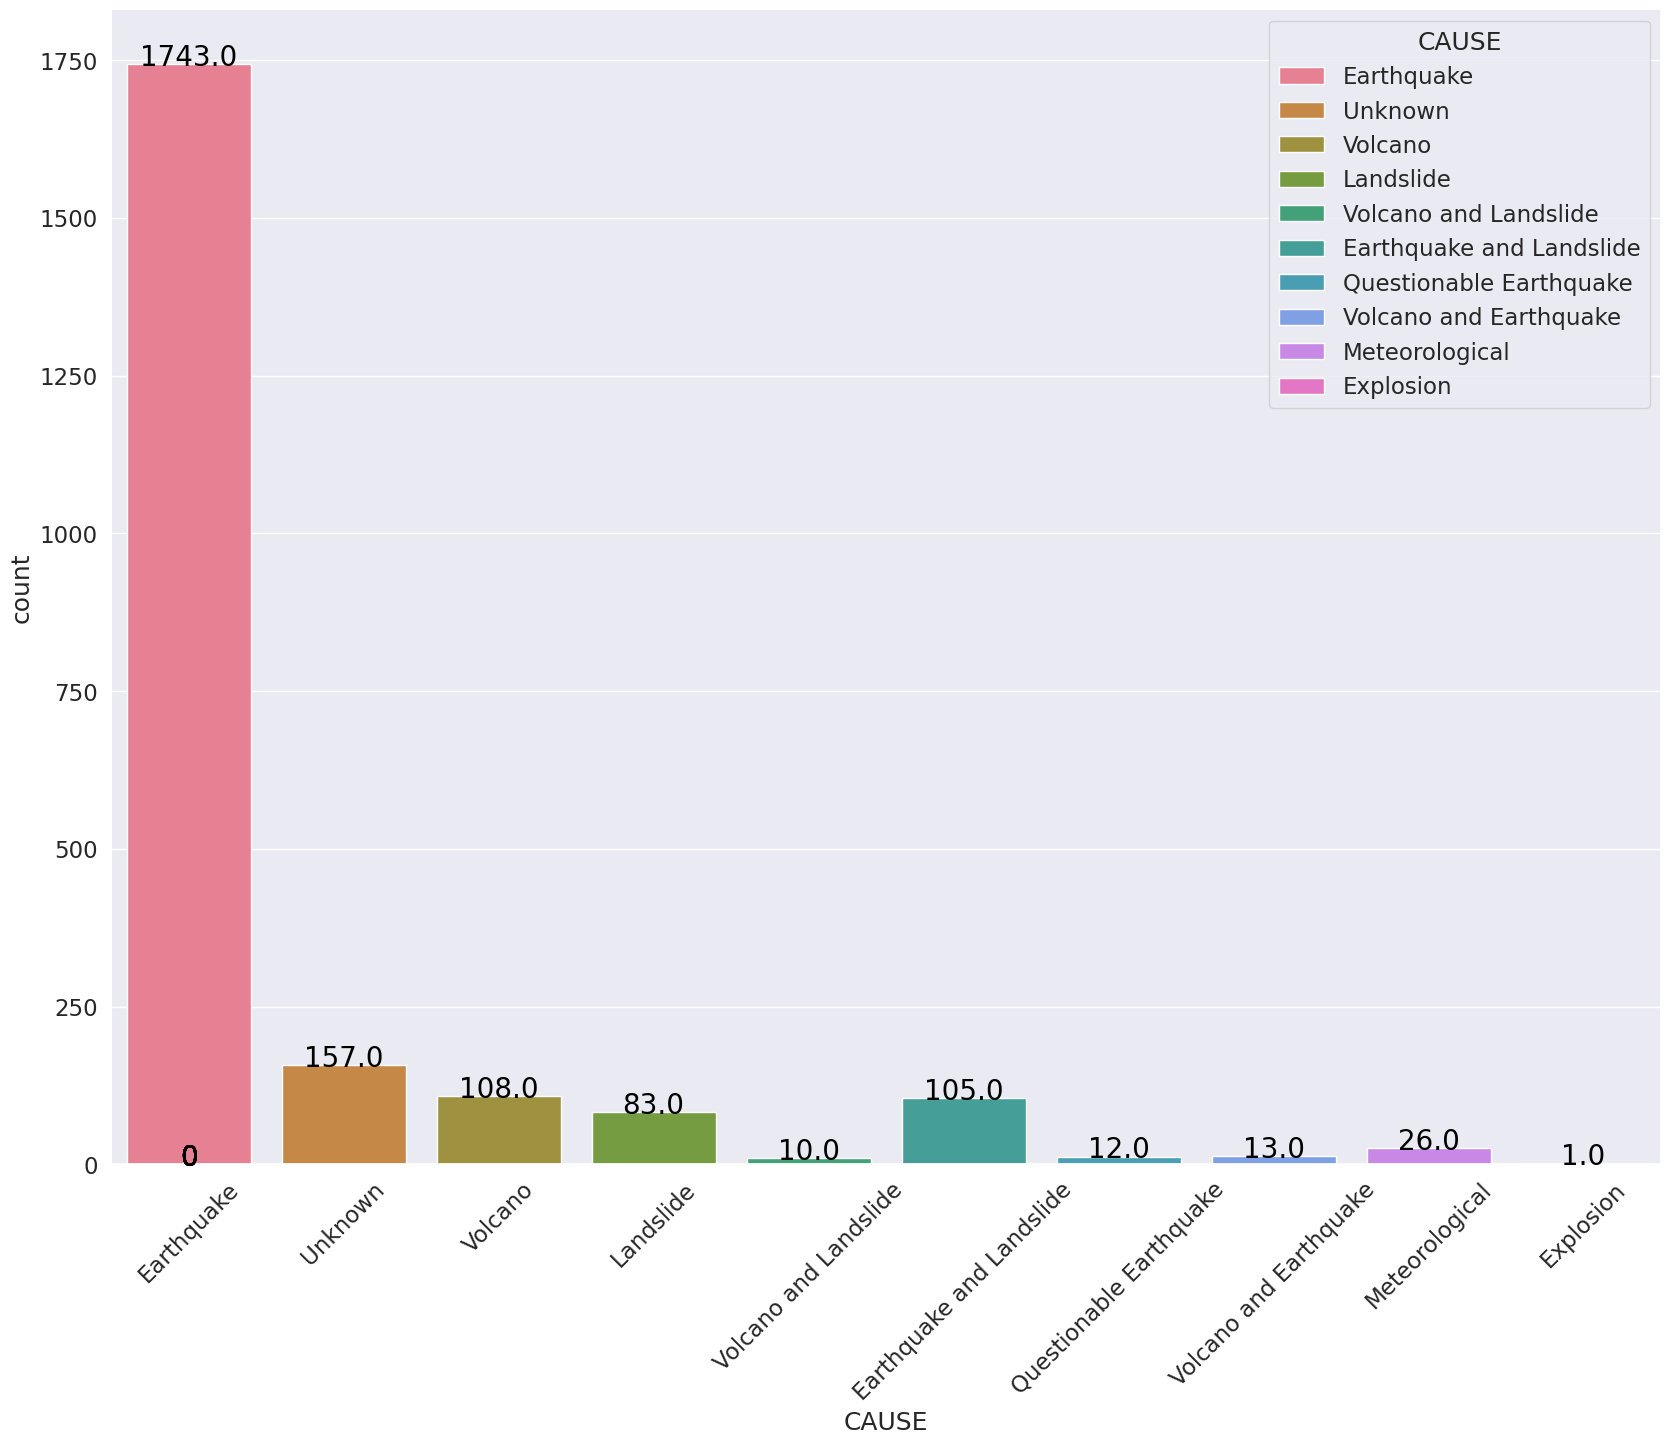

In [ ]:
ax = sns.countplot(df, x = 'CAUSE', hue = 'CAUSE')
plt.xticks(rotation=45)
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=20, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

(<Figure size 2000x1500 with 3 Axes>,
 array([<Axes: xlabel='MONTH', ylabel='count'>,
        <Axes: xlabel='DAY', ylabel='count'>,
        <Axes: xlabel='HOUR', ylabel='count'>], dtype=object))

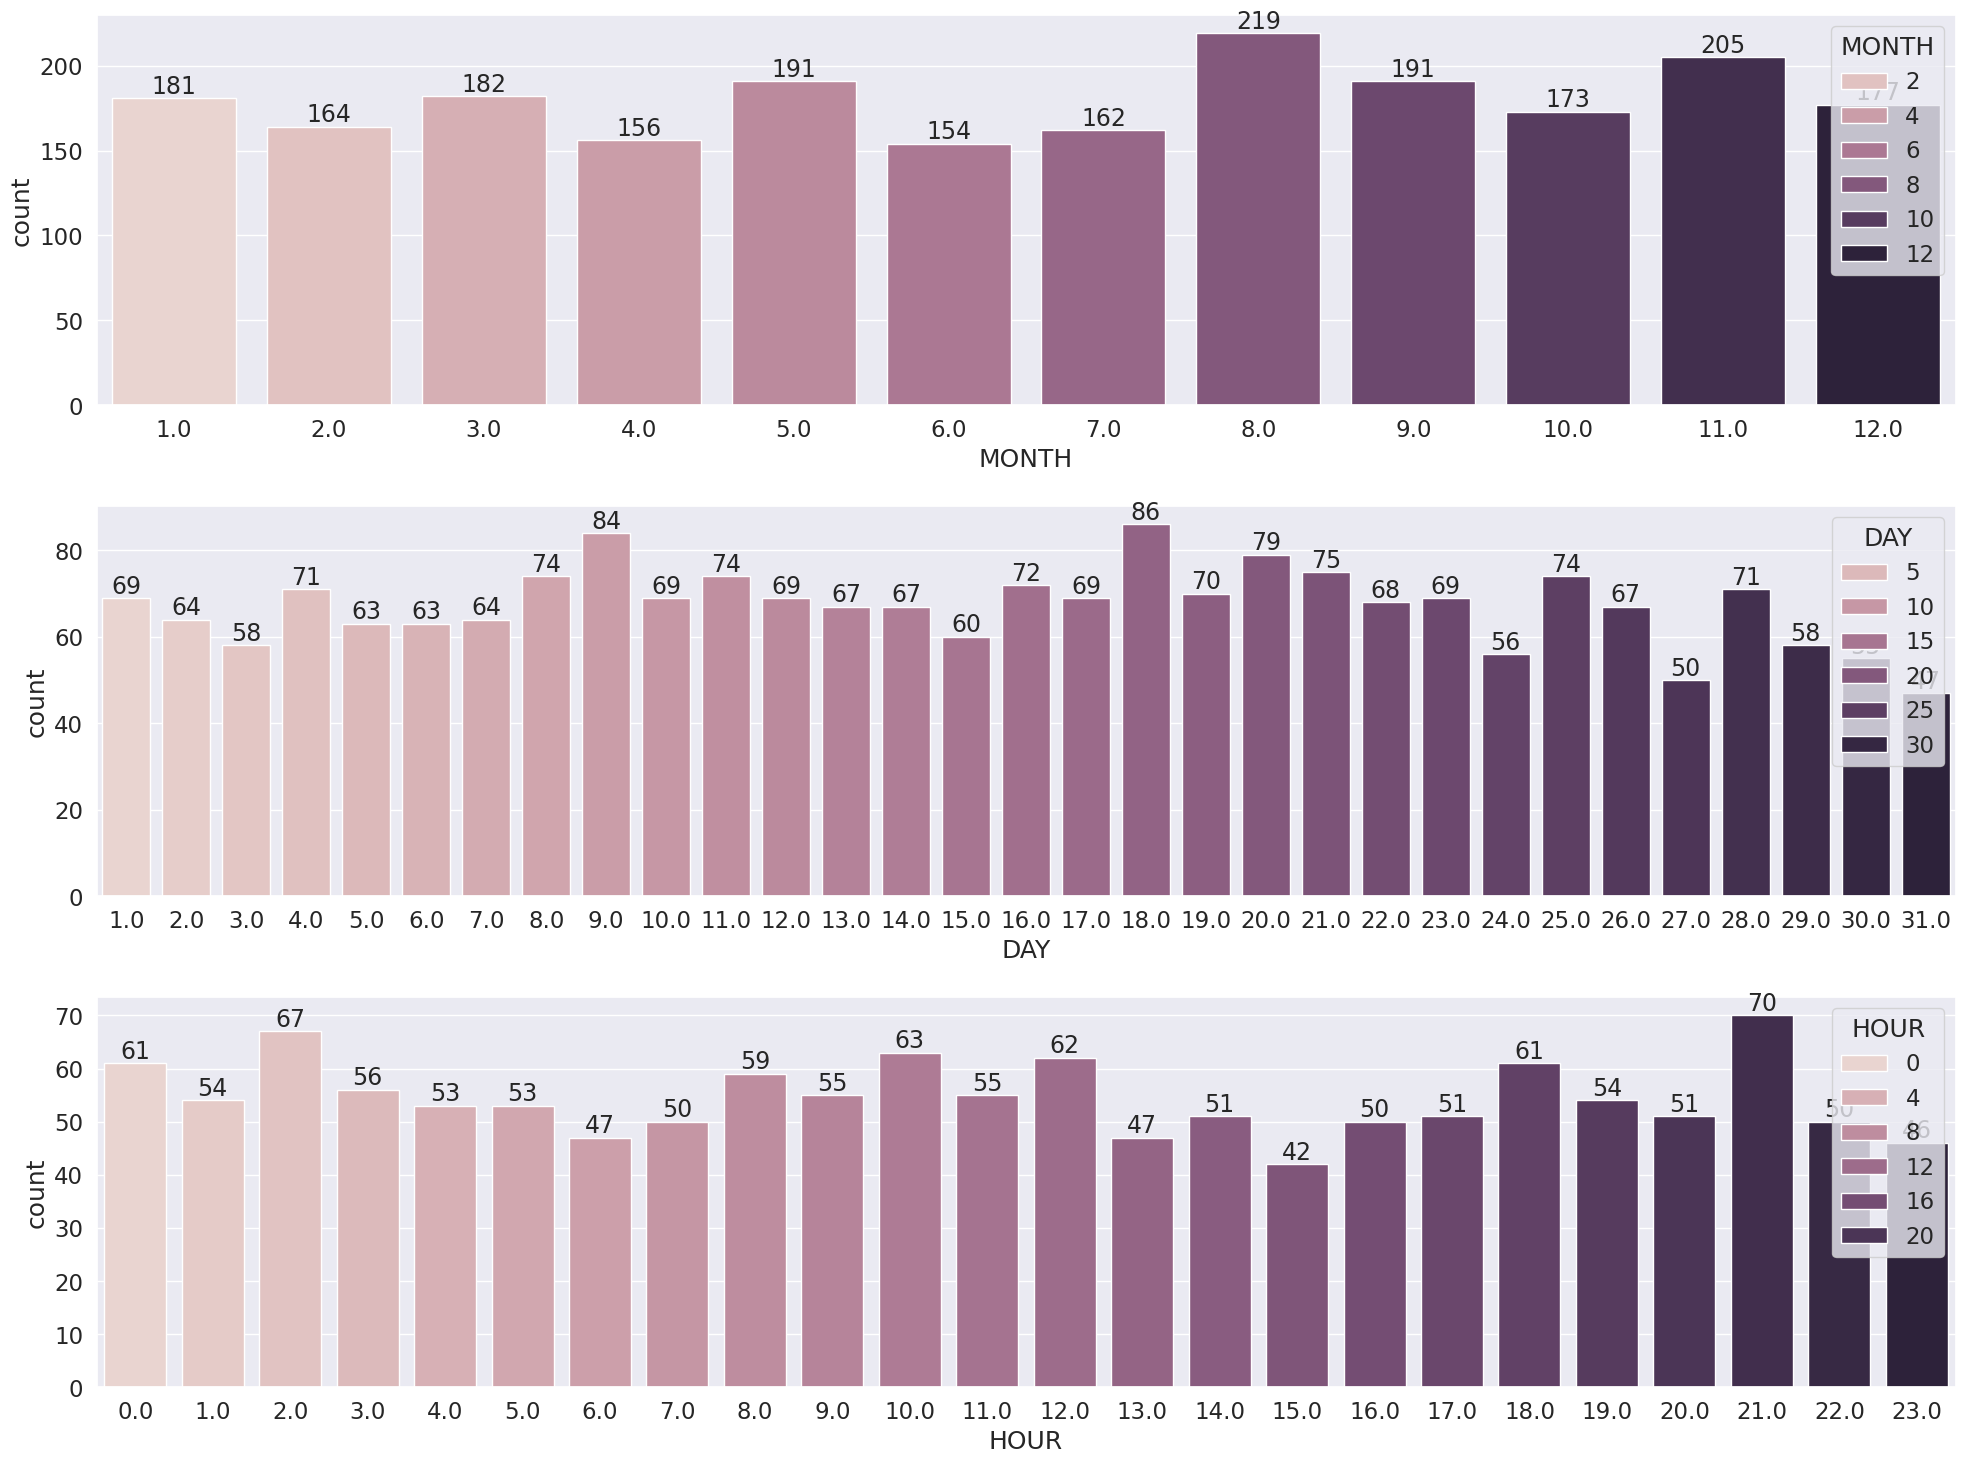

In [ ]:
visualize(df.loc[:, categorical1])

(<Figure size 2000x2000 with 4 Axes>,
 array([<Axes: xlabel='EVENT_VALIDITY', ylabel='count'>,
        <Axes: xlabel='DAMAGE_TOTAL_DESCRIPTION', ylabel='count'>,
        <Axes: xlabel='HOUSES_TOTAL_DESCRIPTION', ylabel='count'>,
        <Axes: xlabel='DEATHS_TOTAL_DESCRIPTION', ylabel='count'>],
       dtype=object))

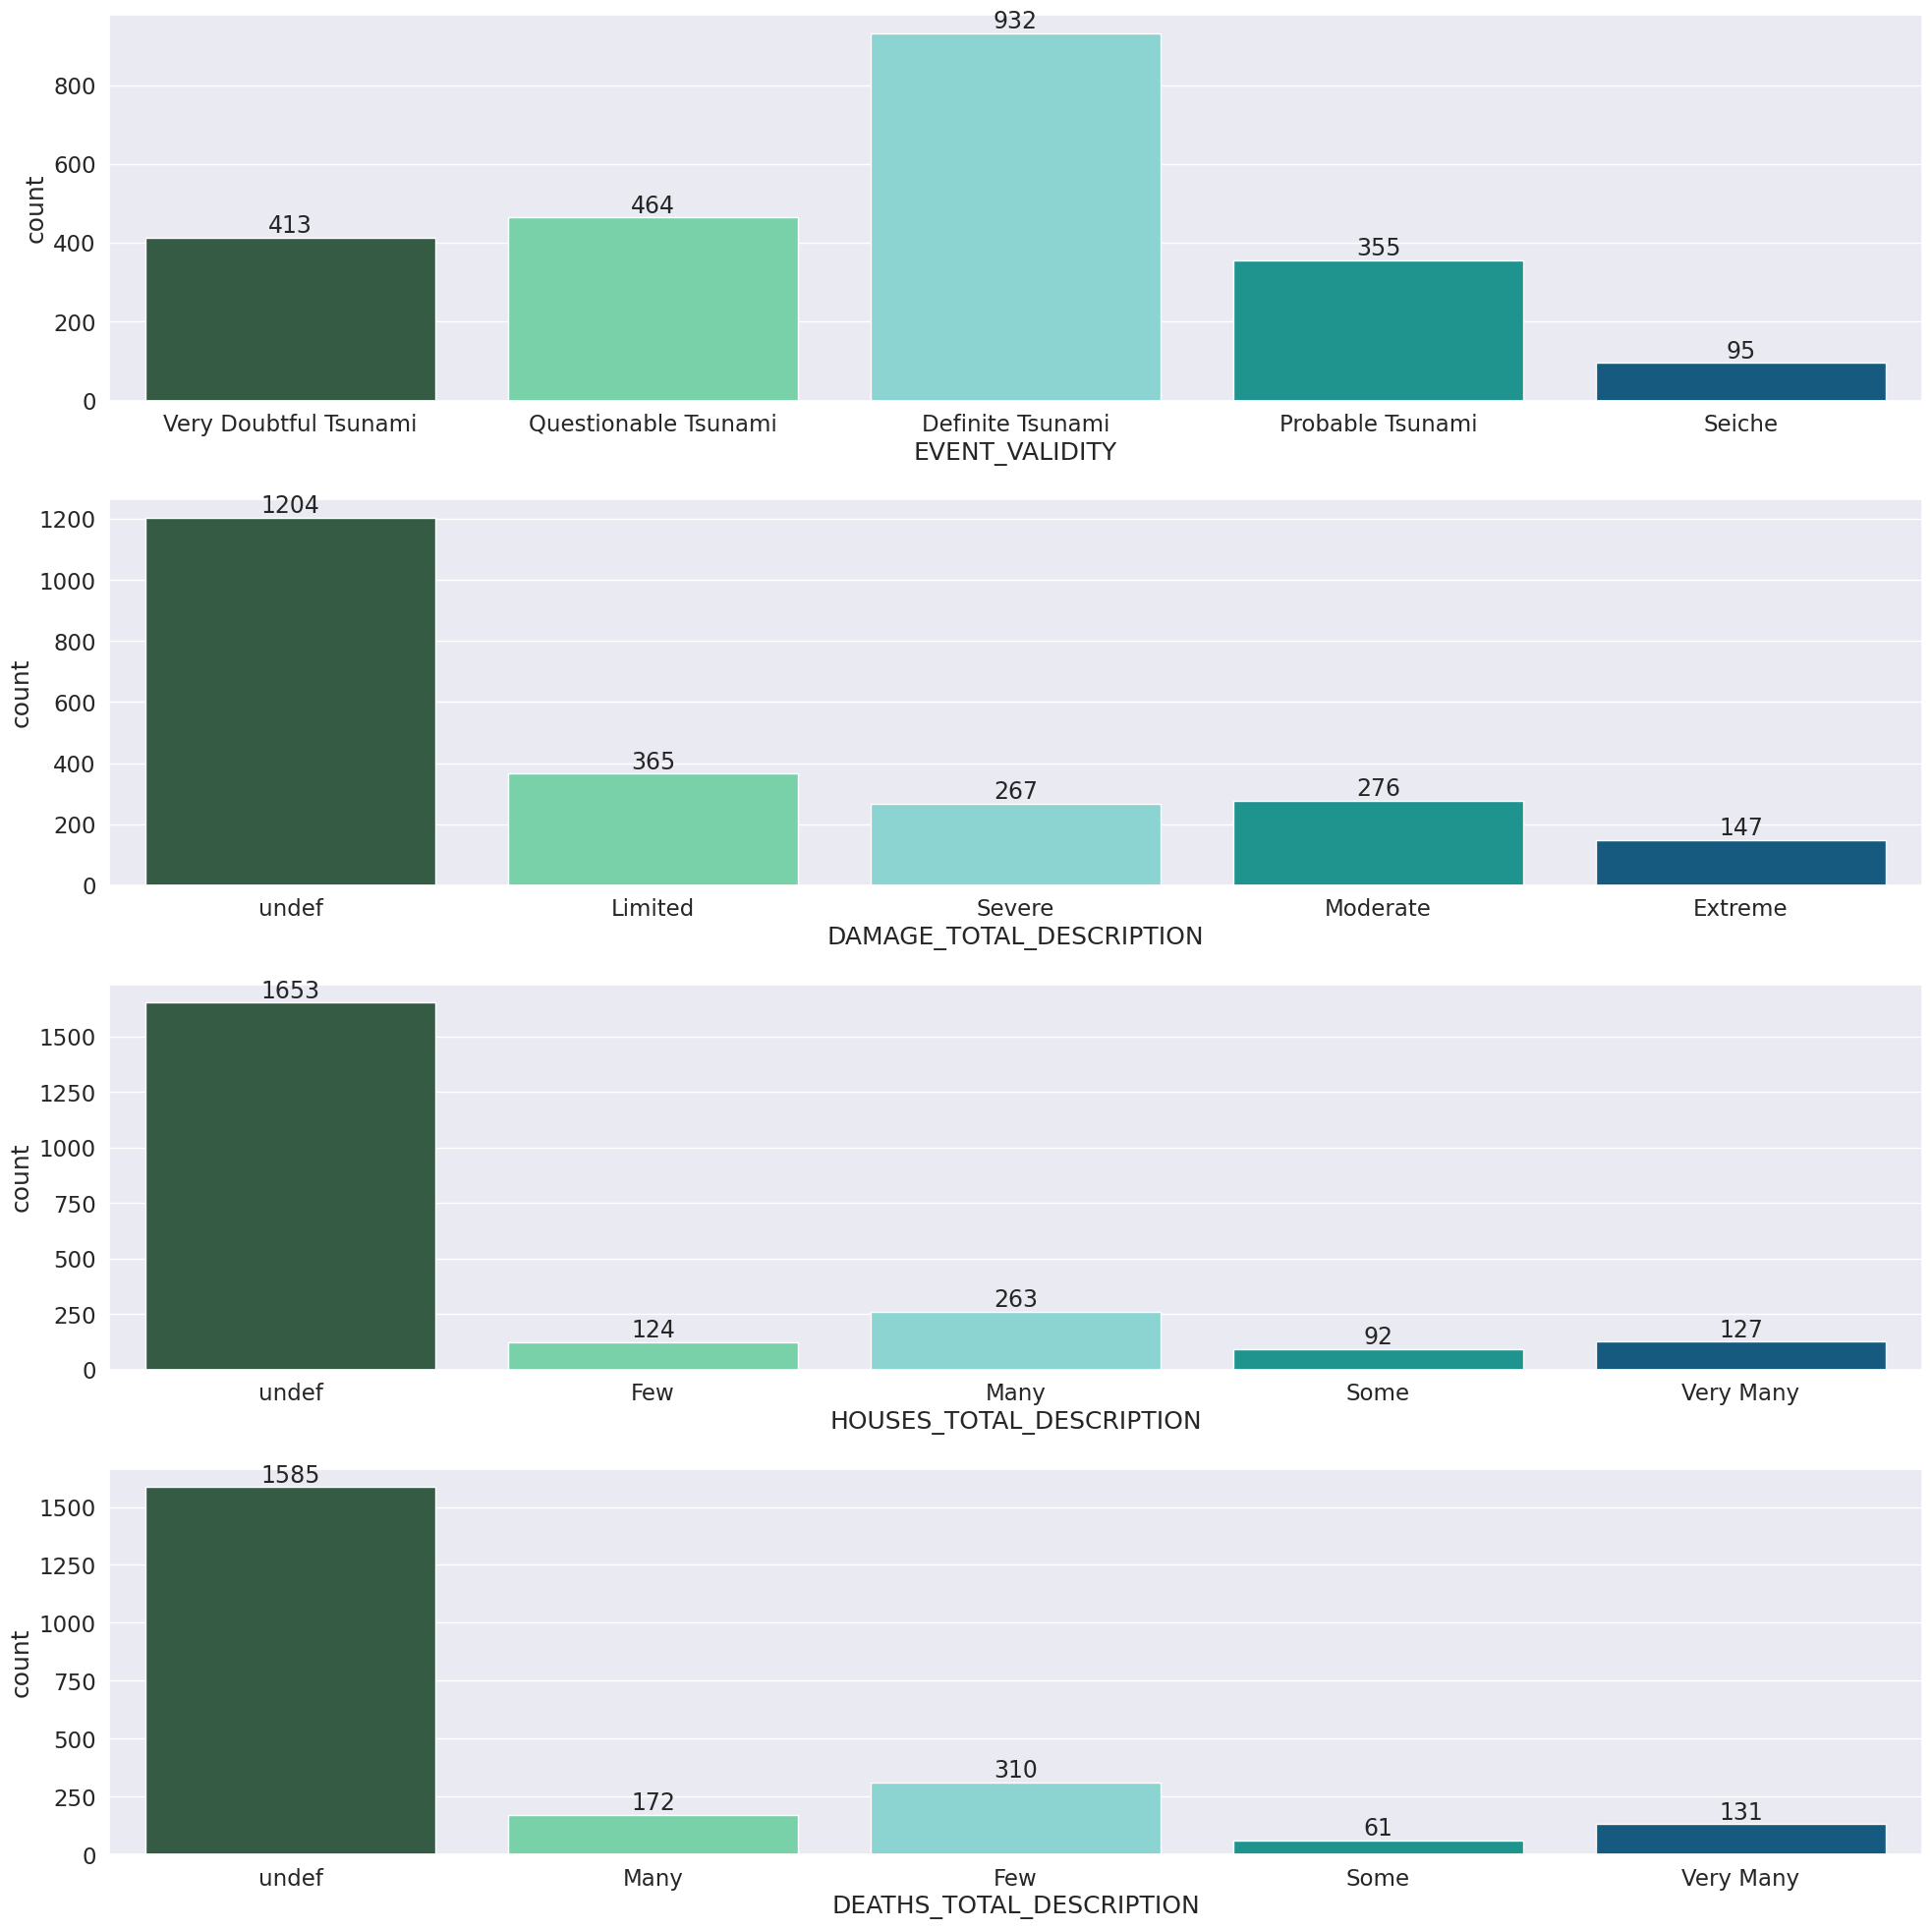

In [ ]:
visualize(df.loc[:, categorical2])

In [ ]:
df['DAMAGE'] = df.apply(combine_values, axis=1)
df['DAMAGE'] = df['DAMAGE'].apply(undef)

In [ ]:
df.drop(columns = ['DAMAGE_TOTAL_DESCRIPTION','HOUSES_TOTAL_DESCRIPTION', 'DEATHS_TOTAL_DESCRIPTION'], inplace=True)

In [ ]:
df.columns

Index(['ID', 'YEAR', 'MONTH', 'DAY', 'HOUR', 'MINUTE', 'LATITUDE', 'LONGITUDE',
       'LOCATION_NAME', 'COUNTRY', 'REGION', 'CAUSE', 'EVENT_VALIDITY',
       'EQ_MAGNITUDE', 'EQ_DEPTH', 'TS_INTENSITY', 'URL', 'COMMENTS',
       'DAMAGE'],
      dtype='object')

In [ ]:
(df['DAMAGE'] != 'undef').sum()

1123

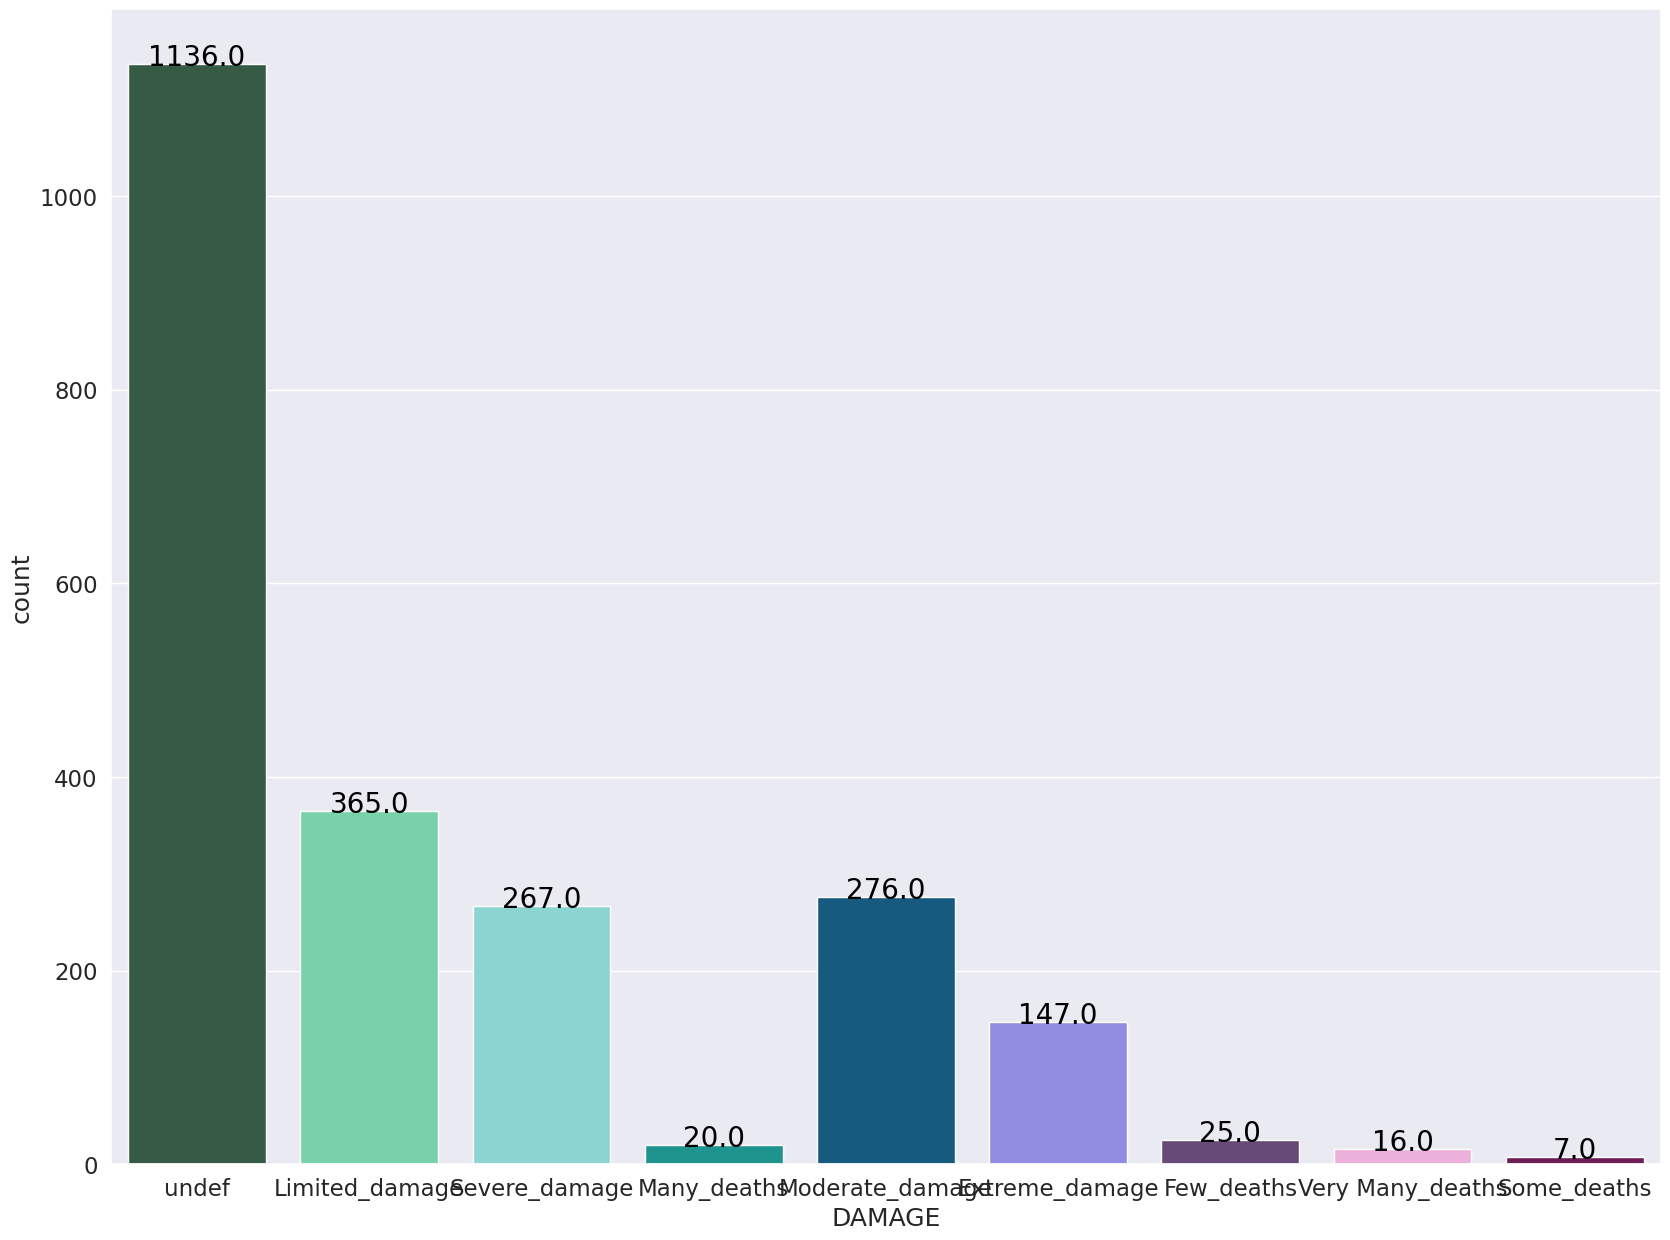

In [ ]:
ax = sns.countplot(df, x = 'DAMAGE', hue = 'DAMAGE')
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=20, color='black', xytext=(0, 5),
                textcoords='offset points')

### Numerical

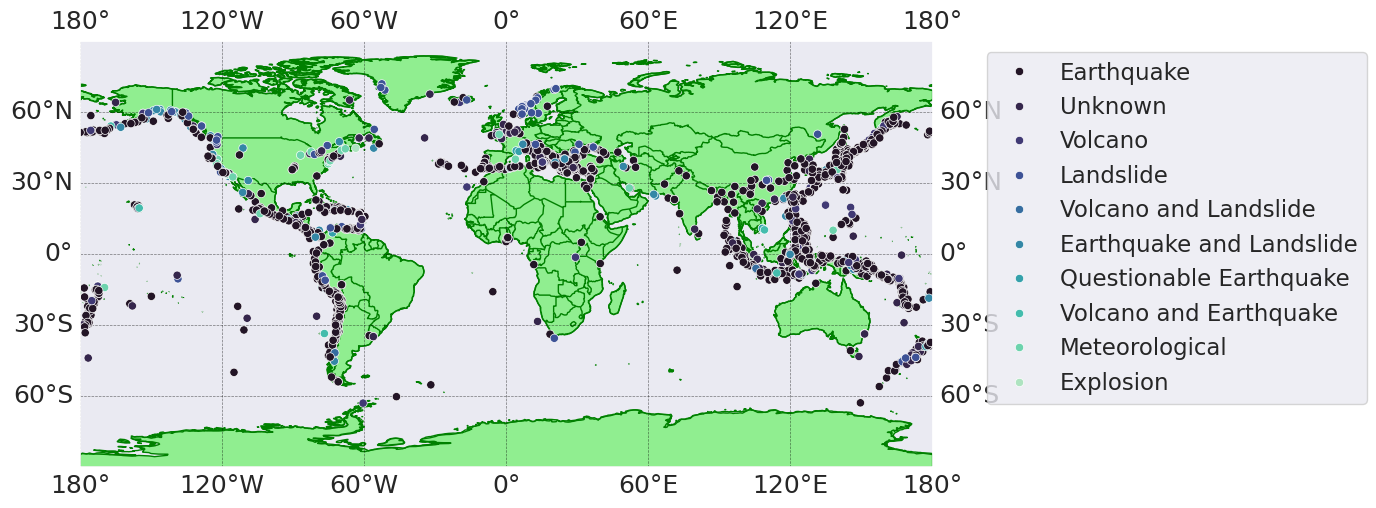

In [ ]:
fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90])
ax.add_feature(cfeature.LAND, facecolor='lightgreen', edgecolor='green', zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='green', zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='green', zorder=0)

ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='--')

scatter = sns.scatterplot(df, x = 'LONGITUDE', y = 'LATITUDE', hue = 'CAUSE', palette = "mako", ax = ax, zorder=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 1)

plt.show()



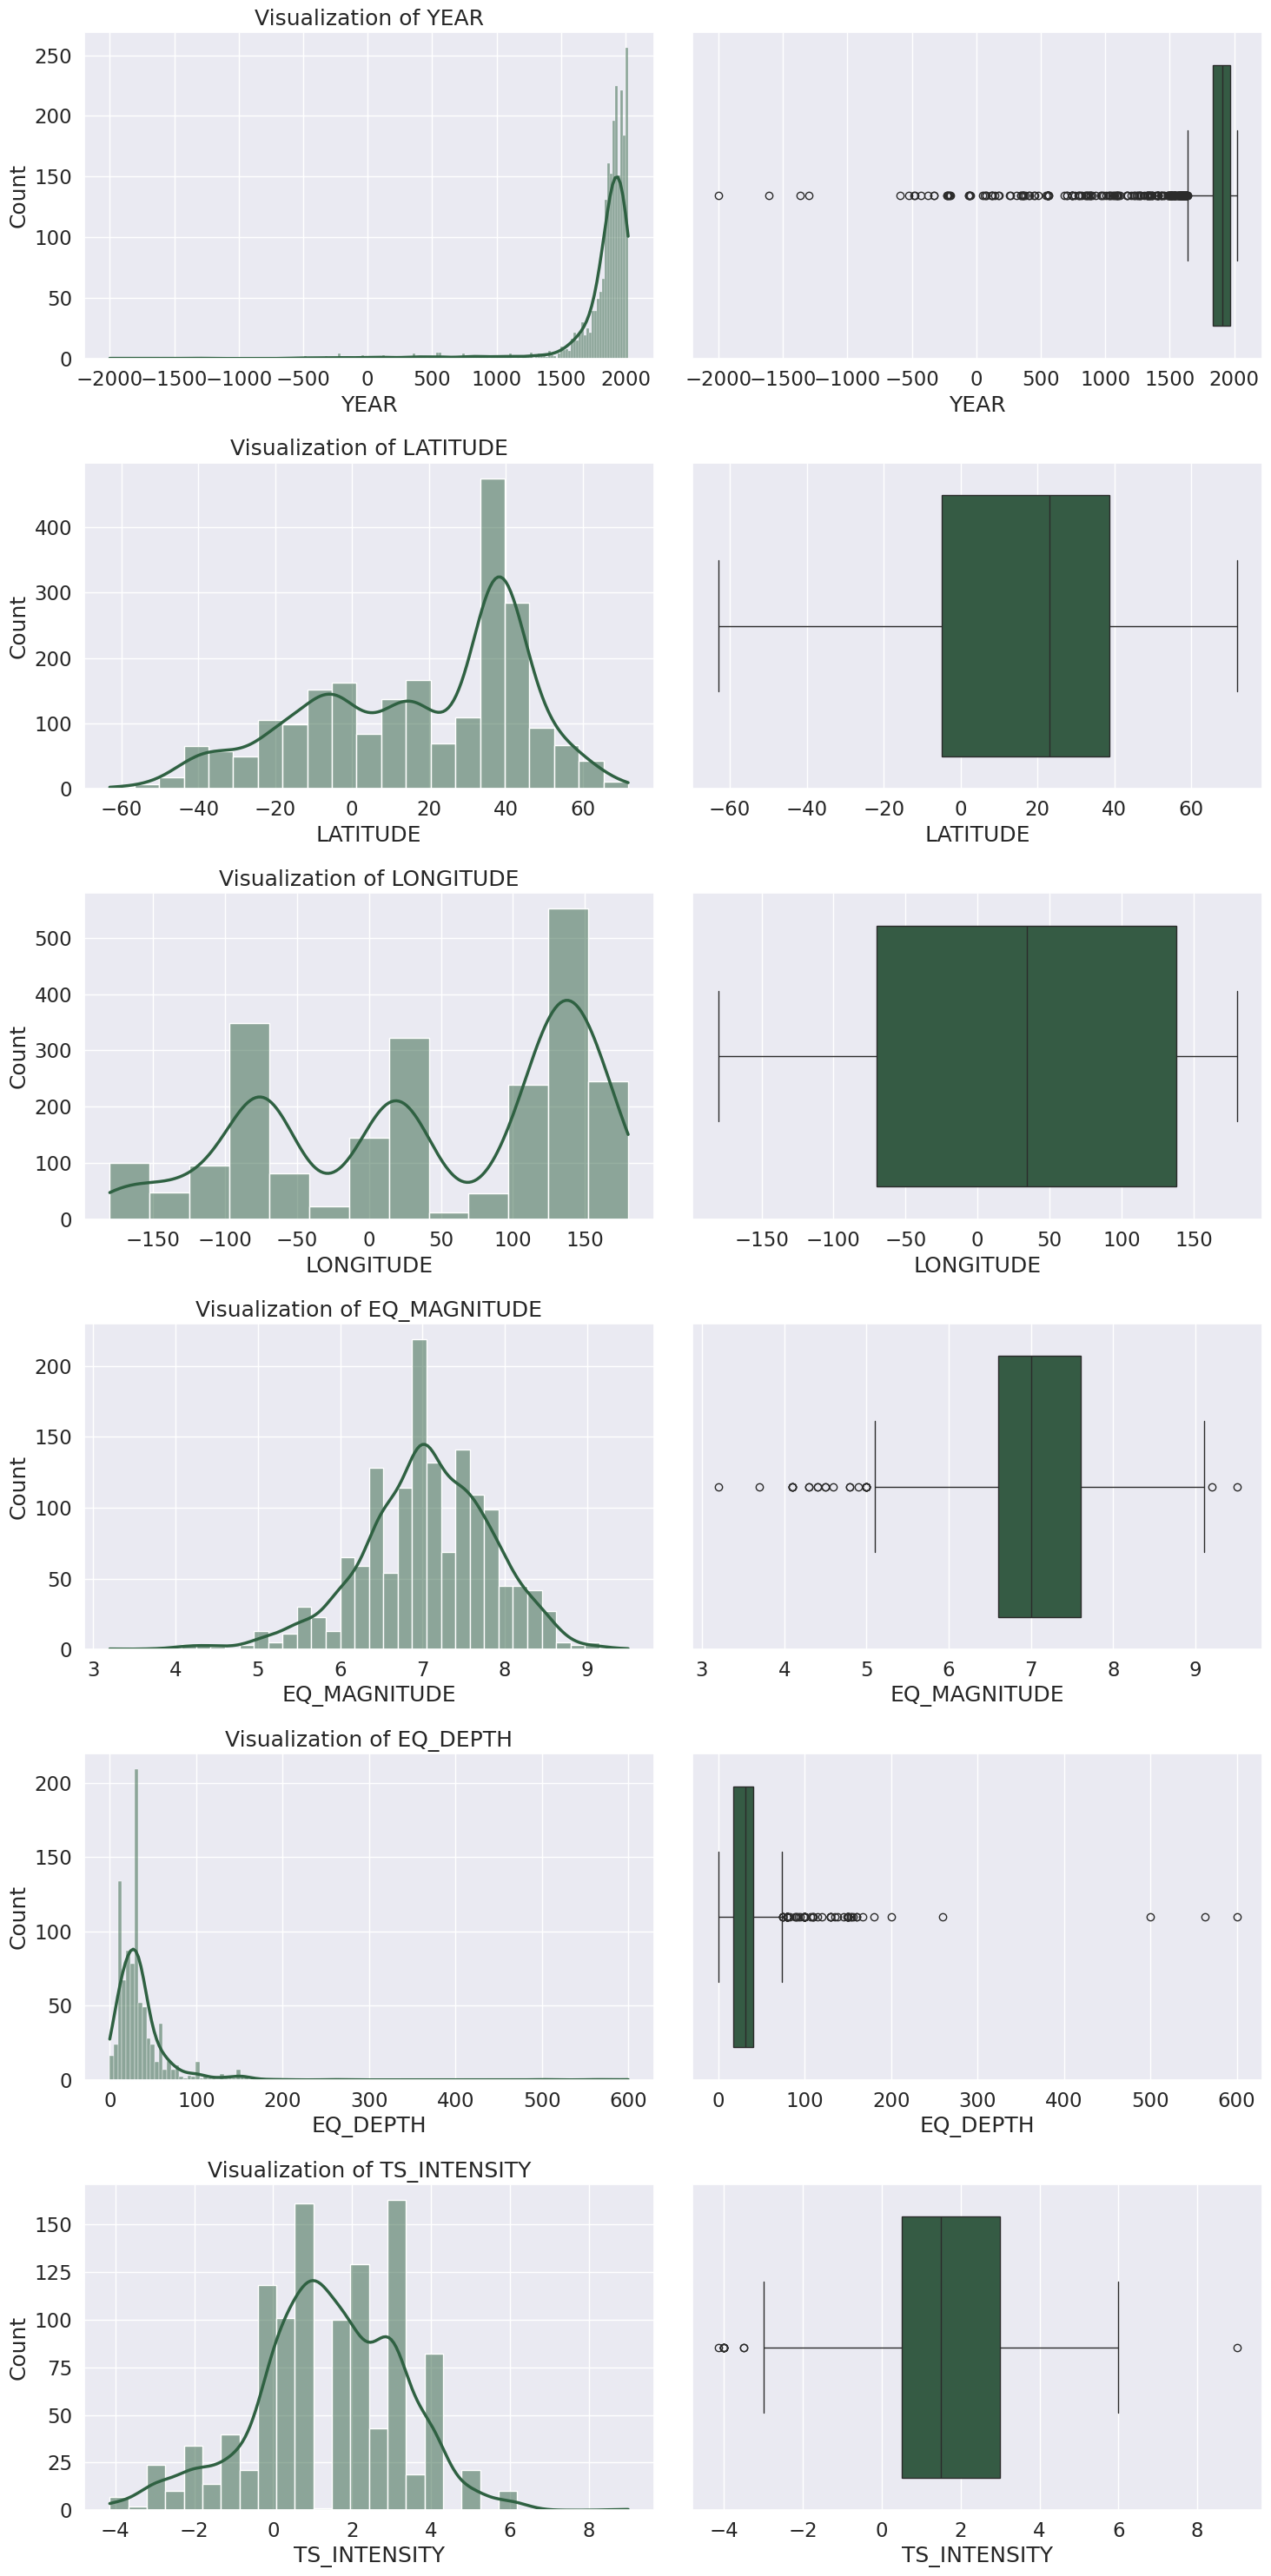

In [ ]:
numerical_visualize(df.loc[:, numerical])

In [ ]:
categorical = ['MONTH', 'DAY', 'HOUR', 'MINUTE', 'REGION', 'CAUSE', 'EVENT_VALIDITY',
       'DAMAGE']
numerical = [i for i in df.columns.to_list() if i not in categorical and i not in ['LOCATION_NAME', 'COUNTRY', 'EQ_DEPTH', 'ID','URL', 'COMMENTS']]

In [ ]:
numerical

['YEAR', 'LATITUDE', 'LONGITUDE', 'EQ_MAGNITUDE', 'TS_INTENSITY']

### Preprocessing

In [ ]:
mapper = DataFrameMapper(
    gen_features(
        columns = [ ['REGION'], ['CAUSE']],
        classes = [{'class': SimpleImputer, 'strategy': 'most_frequent'},
                    {'class': CountEncoder},
                    {'class': StandardScaler}]
    )+gen_features(
        columns = [['EQ_MAGNITUDE'], ['TS_INTENSITY']],
        classes = [{'class': KNNImputer, 'n_neighbors': 7, 'weights': 'distance'},
                    {'class': MinMaxScaler}]
    )
    +gen_features(
        columns=[['EVENT_VALIDITY'], ['DAMAGE']],
        classes=[OneHotEncoder, StandardScaler]
    ) +
    gen_features(
        columns = [ ['MONTH']],
        classes = [{'class': SimpleImputer, 'strategy': 'most_frequent'},
                    {'class': MonthTransform}]
    )
    + [(['LATITUDE', 'LONGITUDE'], [RadianTransform(), MinMaxScaler()])],
    default=None,
    drop_cols=['EQ_DEPTH','YEAR', 'DAY' ,'HOUR', 'MINUTE', 'LOCATION_NAME', 'COUNTRY', 'ID','URL', 'COMMENTS'],
    df_out= True
)
df_mapped = mapper.fit_transform(df)

In [ ]:
df_mapped

REGION     CAUSE  EQ_MAGNITUDE  TS_INTENSITY  EVENT_VALIDITY_0_1  \
0     1.616311  0.543174      0.603175      0.419862            2.114174   
1    -1.097789 -1.767216      0.610583      0.419862            2.114174   
2     1.616311  0.543174      0.610583      0.543379           -0.472998   
3    -0.344409 -1.767216      0.610583      0.391172            2.114174   
4     1.616311 -1.767216      0.444444      0.695586           -0.472998   
...        ...       ...           ...           ...                 ...   
2254 -1.242670  0.543174      0.730159      0.419862           -0.472998   
2255 -0.479631  0.543174      0.666667      0.419862           -0.472998   
2256 -0.489290  0.543174      0.444444      0.419862           -0.472998   
2257 -0.498948  0.543174      0.610583      0.419862            2.114174   
2258 -0.489290  0.543174      0.666667      0.419862           -0.472998   

      EVENT_VALIDITY_0_2  EVENT_VALIDITY_0_3  EVENT_VALIDITY_0_4  \
0              -0.508425           -0.838055           -0.431798   
1              -0.508425           -0.838055           -0.431798   
2               1.966859           -0.838055           -0.431798   
3              -0.508425           -0.838055           -0.431798   
4               1.966859           -0.838055           -0.431798   
...                  ...                 ...                 ...   
2254           -0.508425            1.193239           -0.431798   
2255           -0.508425            1.193239           -0.431798   
2256           -0.508425           -0.838055            2.315897   
2257           -0.508425           -0.838055           -0.431798   
2258           -0.508425            1.193239           -0.431798   

      EVENT_VALIDITY_0_5  DAMAGE_0_1  ...  DAMAGE_0_3  DAMAGE_0_4  DAMAGE_0_5  \
0              -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
1              -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
2              -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
3              -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
4              -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
...                  ...         ...  ...         ...         ...         ...   
2254           -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
2255           -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
2256           -0.209524    0.994262  ...   -0.366109   -0.094512   -0.373072   
2257           -0.209524   -1.005771  ...    2.731423   -0.094512   -0.373072   
2258           -0.209524   -1.005771  ...   -0.366109   -0.094512   -0.373072   

      DAMAGE_0_6  DAMAGE_0_7  DAMAGE_0_8  DAMAGE_0_9         MONTH  \
0      -0.263822   -0.105786   -0.084459   -0.055753 -5.000000e-01   
1      -0.263822   -0.105786   -0.084459   -0.055753  5.000000e-01   
2      -0.263822   -0.105786   -0.084459   -0.055753 -5.000000e-01   
3      -0.263822   -0.105786   -0.084459   -0.055753  0.000000e+00   
4      -0.263822   -0.105786   -0.084459   -0.055753 -5.000000e-01   
...          ...         ...         ...         ...           ...   
2254   -0.263822   -0.105786   -0.084459   -0.055753  1.224647e-16   
2255   -0.263822   -0.105786   -0.084459   -0.055753  5.000000e-01   
2256   -0.263822   -0.105786   -0.084459   -0.055753  1.000000e+00   
2257   -0.263822   -0.105786   -0.084459   -0.055753  5.000000e-01   
2258    3.790428   -0.105786   -0.084459   -0.055753  5.000000e-01   

      LATITUDE_LONGITUDE_0  LATITUDE_LONGITUDE_1  
0                 0.764021              0.569435  
1                 0.848954              0.492806  
2                 0.734944              0.600689  
3                 0.764021              0.855582  
4                 0.763725              0.572880  
...                    ...                   ...  
2254              0.875509              0.059588  
2255              0.220350              0.005926  
2256 

In [ ]:
df_mapped.shape

(2259, 21)

## K-means

In [ ]:
kmeans2 = KMeans(n_clusters = 2, random_state = 0, n_init='auto')
kmeans2.fit(df_mapped)

KMeans(n_clusters=2, n_init='auto', random_state=0)

In [ ]:
silhouette_avg = silhouette_score(df_mapped, kmeans2.labels_)
calinski_score = calinski_harabasz_score(df_mapped, kmeans2.labels_)

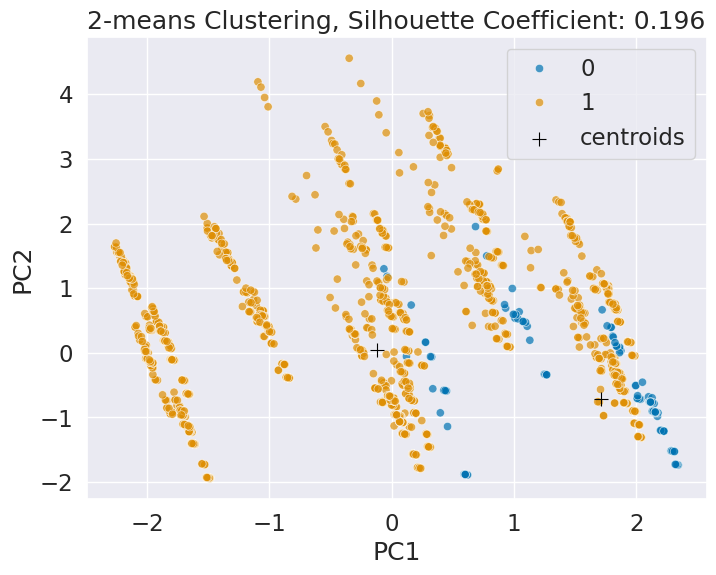

In [ ]:
plot_clusters(df_mapped, kmeans2, 2, silhouette_avg)

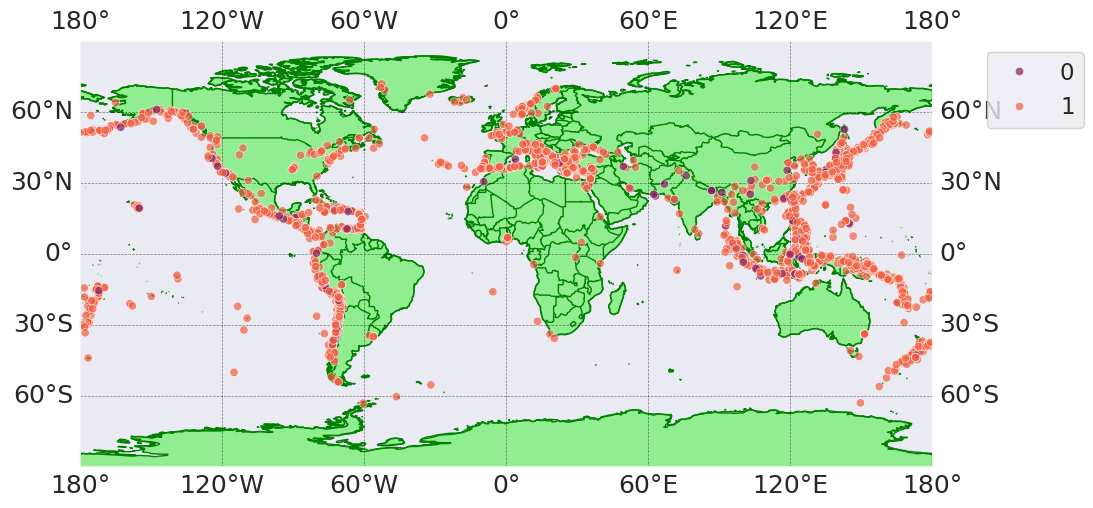

In [ ]:

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90])
ax.add_feature(cfeature.LAND, facecolor='lightgreen', edgecolor='green', zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='green', zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='green', zorder=0)

ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='--')

scatter = sns.scatterplot(df, x='LONGITUDE', y='LATITUDE', hue= kmeans2.predict(df_mapped) , legend='full', alpha=0.7, palette = "rocket", ax = ax, zorder=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 1)

plt.show()


### Selecting the number of clusters with silhouette analysis

In [ ]:
def plot_silhouette_analysis(X, X_raw,  range_n_clusters=[2, 3, 4, 5, 6]):

    inertia = []

    fig, axs = plt.subplots(nrows= len(range_n_clusters), ncols= 2, figsize=(18, len(range_n_clusters) * 7))

    for i, n_clusters in enumerate(range_n_clusters):
        clusterer = KMeans(n_clusters=n_clusters, random_state=0)
        cluster_labels = clusterer.fit_predict(X.values)
        inertia.append(clusterer.inertia_)

        silhouette_avg = silhouette_score(X.values, cluster_labels)

        # Compute silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X.values, cluster_labels)

        y_lower = 10
        for j in range(n_clusters):
            ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == j]
            ith_cluster_silhouette_values.sort()
            size_cluster_j = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_j

            axs[i, 0].fill_betweenx(
                np.arange(y_lower, y_upper),
                0,
                ith_cluster_silhouette_values,
                facecolor=plt.cm.viridis(float(j) / n_clusters),
                edgecolor=plt.cm.viridis(float(j) / n_clusters),
                alpha=0.7,
            )

            axs[i, 0].text(-0.05, y_lower + 0.5 * size_cluster_j, str(j))

            y_lower = y_upper + 10  # 10 for the 0 samples

        axs[i, 0].set_title(f"Silhouette plot for {n_clusters} clusters")
        axs[i, 0].set_xlabel("Silhouette coefficient values")
        axs[i, 0].set_ylabel("Cluster label")

        axs[i, 0].axvline(x=silhouette_avg, color="red", linestyle="--")
        axs[i, 0].set_yticks([])
        axs[i, 0].set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


        pca = PCA(n_components=2)
        pca_result = pca.fit_transform(X)
        pca_df = pd.DataFrame(data=pca_result, columns=['PC1', 'PC2'])

        #sns.scatterplot(X_raw, x='LONGITUDE', y='LATITUDE', hue=cluster_labels, palette='Set1', legend='full', alpha=0.7, ax=axs[i, 1])
        sns.scatterplot(x=pca_df['PC1'], y=pca_df['PC2'], hue=cluster_labels, palette='Set1', legend='full', alpha=0.7, ax=axs[i, 1])
        centroids = pca.transform(clusterer.cluster_centers_)
        sns.scatterplot(x=centroids[:,0], y=centroids[:,1], marker='x', s=100, c='black', label='Centroids', ax=axs[i, 1])

        axs[i, 1].set_title("Clustered data for {} clusters".format(n_clusters))
        axs[i, 1].set_xlabel("Longitude")
        axs[i, 1].set_ylabel("Latitude")

    plt.tight_layout()
    plt.show()
    return inertia

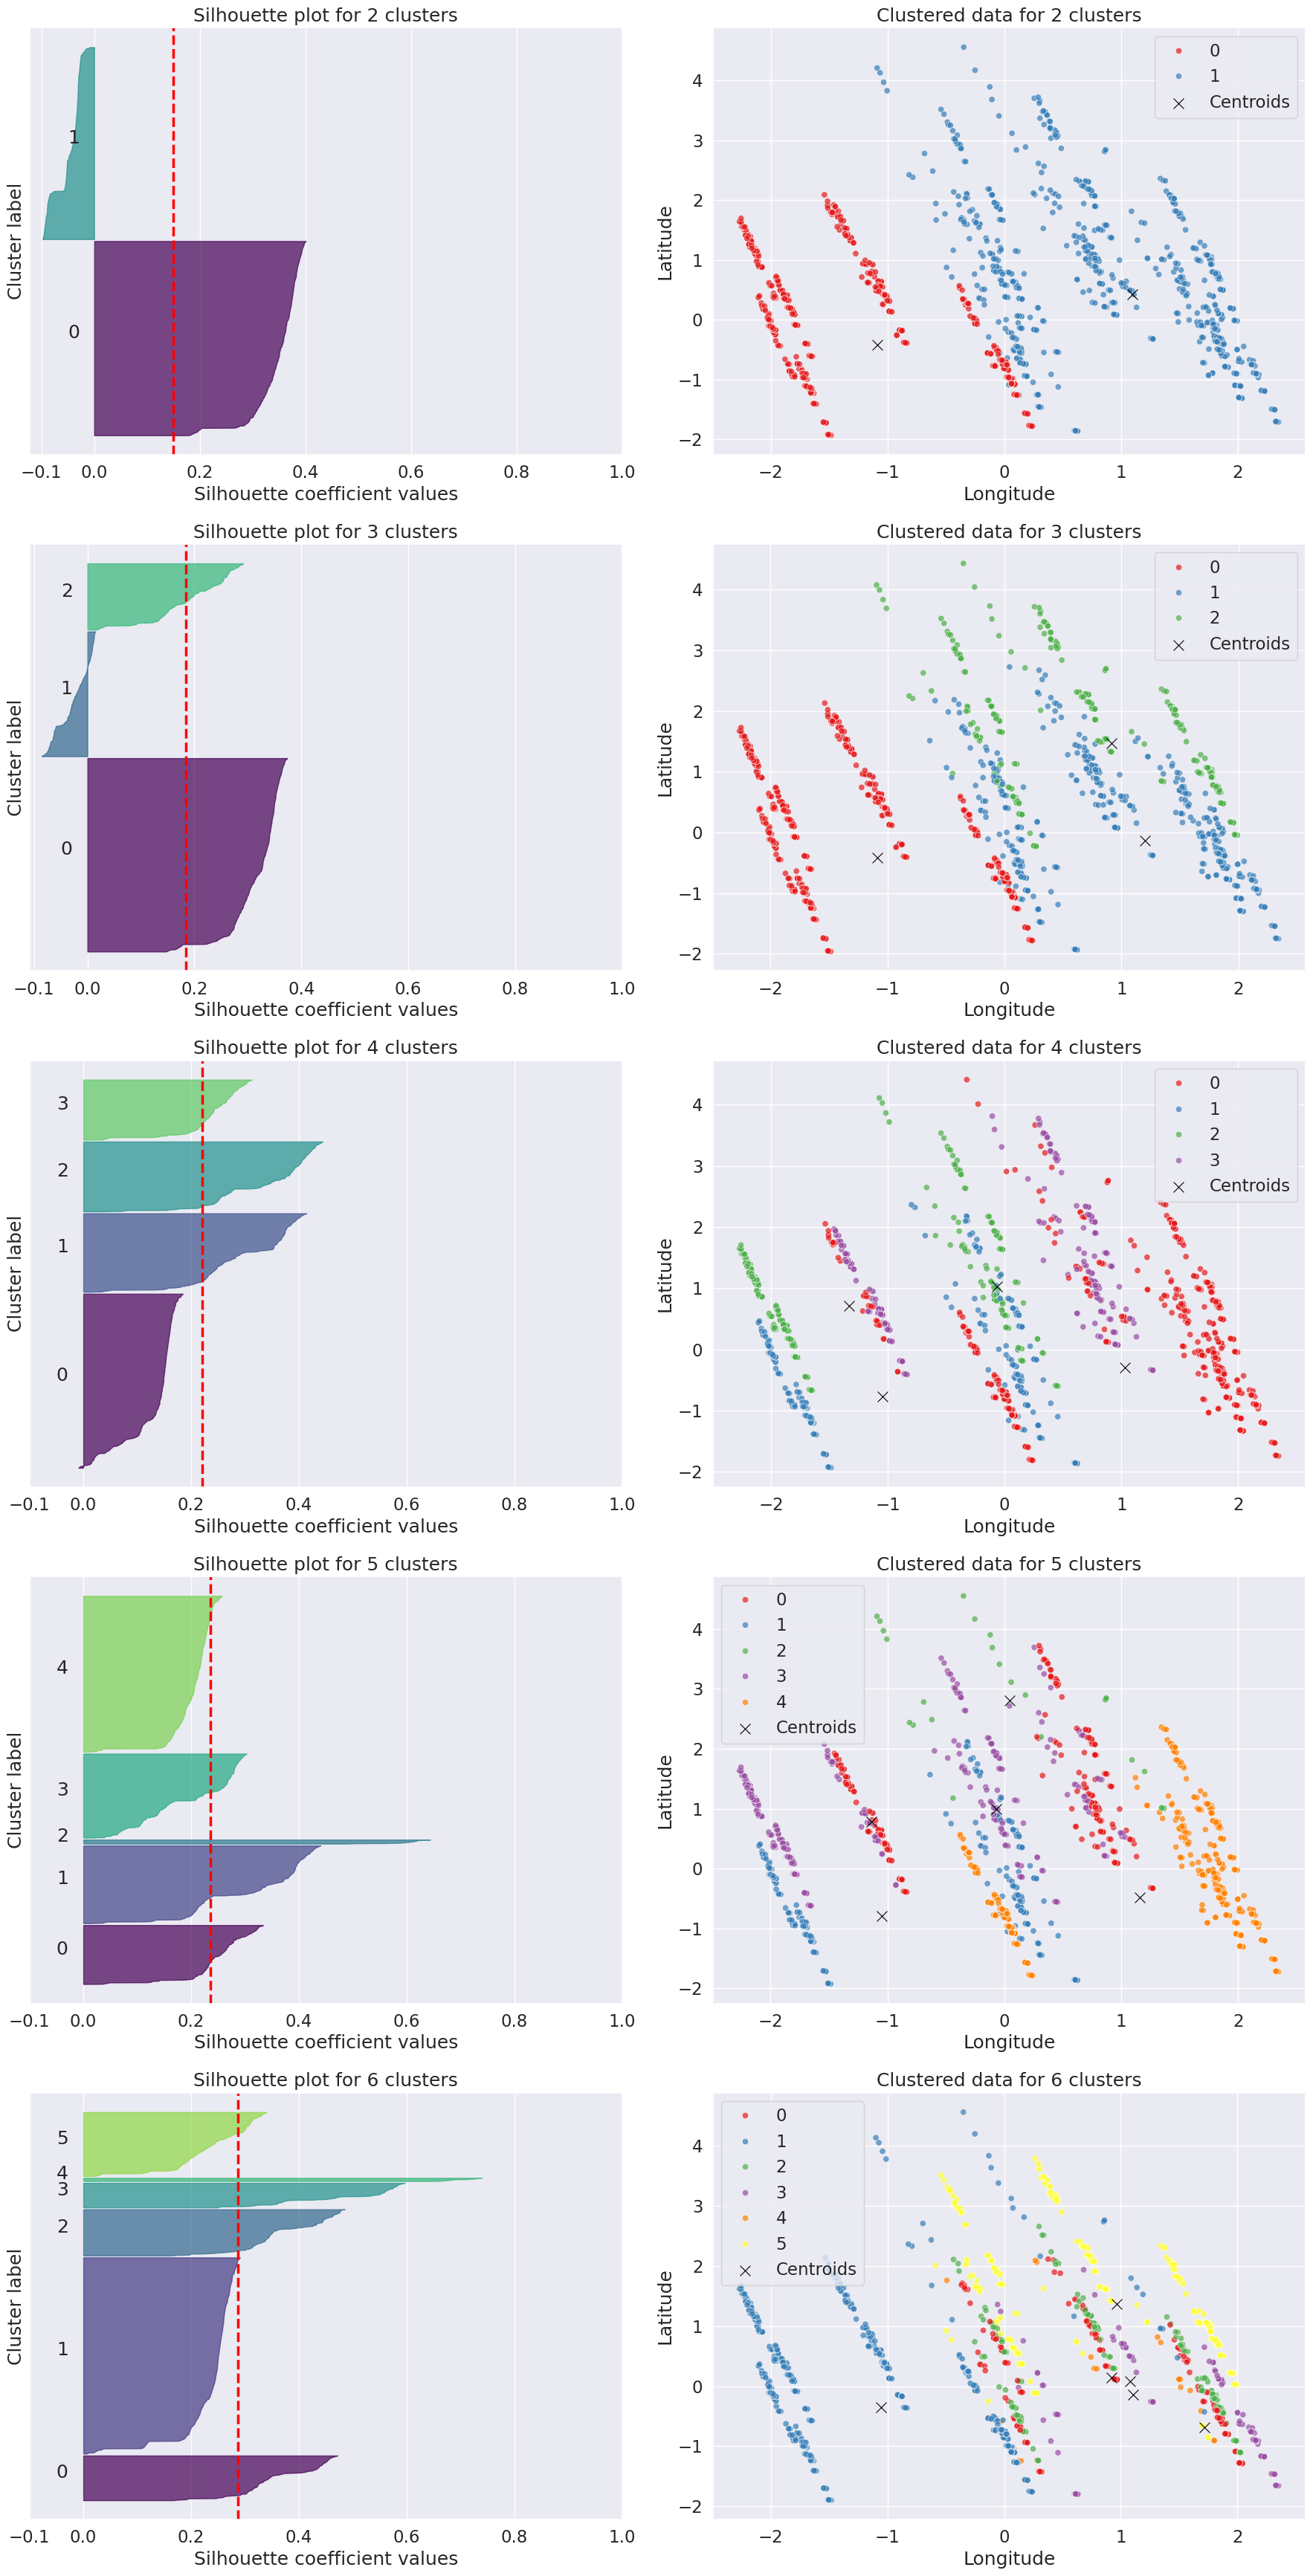

In [ ]:
inertia = plot_silhouette_analysis(df_mapped, df, range_n_clusters=[2, 3, 4, 5, 6])


<Axes: >

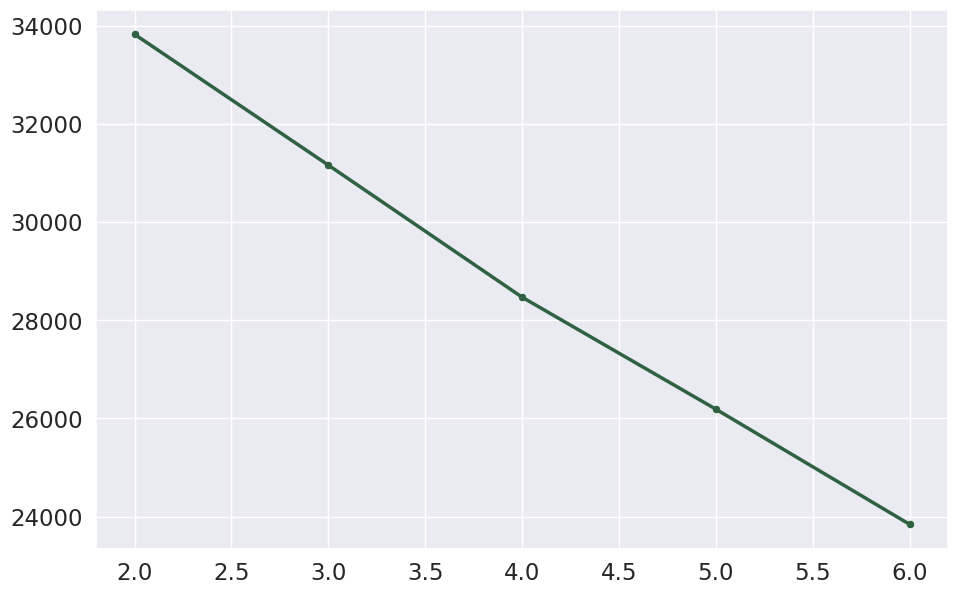

In [ ]:
plt.figure(figsize=(11, 7))
sns.scatterplot(x = [2,3, 4, 5, 6], y = inertia)
sns.lineplot(x = [2, 3, 4, 5, 6], y = inertia)

In [ ]:
kmeans = KMeans(n_clusters = 4, random_state = 0, n_init='auto')
kmeans.fit(df_mapped)

KMeans(n_clusters=4, n_init='auto', random_state=0)

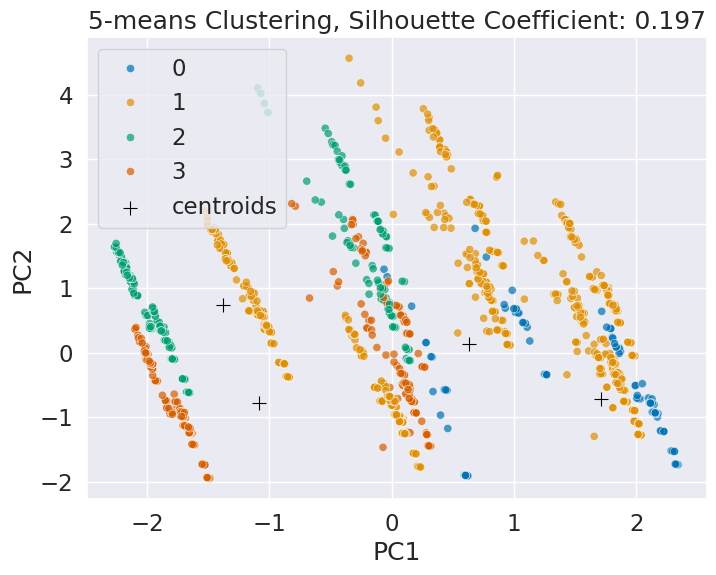

In [ ]:
silhouette_avg = silhouette_score(df_mapped, kmeans.labels_)
plot_clusters(df_mapped, kmeans, 5, silhouette_avg)

In [ ]:
calculate_cluster_scores(df_mapped, kmeans.labels_, '5  clasters')

Model  Silhouette Score  Calinski-Harabasz Score
0  5  clasters          0.197292                217.68933

In [ ]:
calculate_cluster_scores(df_mapped, kmeans2.labels_, '2 clasters')

Model  Silhouette Score  Calinski-Harabasz Score
0  2 clasters          0.196425               167.109122

In [ ]:
kmeans.inertia_

29139.33965081378

In [ ]:
kmeans2.inertia_

34987.8381291175

## DBSCAN

###Empirically calculated eps and min_samples

In [ ]:
neighbors = 6
nbrs = NearestNeighbors(n_neighbors=neighbors ).fit(df_mapped)
distances, indices = nbrs.kneighbors(df_mapped)
distance_desc = sorted(distances[:,neighbors-1], reverse=True)
px.line(x=list(range(1,len(distance_desc )+1)),y= distance_desc )

In [ ]:
kneedle = KneeLocator(range(1,len(distance_desc)+1),  #x values
                      distance_desc, # y values
                      S=1.0, #parameter suggested from paper
                      curve="convex", #parameter from figure
                      direction="decreasing") #parameter from figure

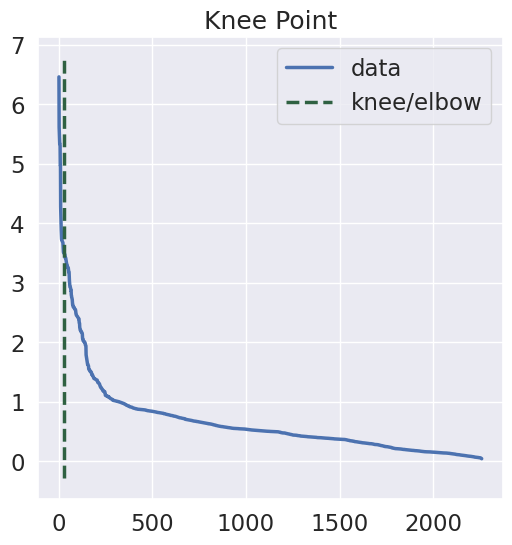

In [ ]:
kneedle.plot_knee()

In [ ]:
eps = kneedle.knee_y
eps

3.501229374104021

### DBSCAN model with empirically selected params

In [ ]:
dbscan = DBSCAN(eps= eps, min_samples= 6)
labels = dbscan.fit_predict(df_mapped)

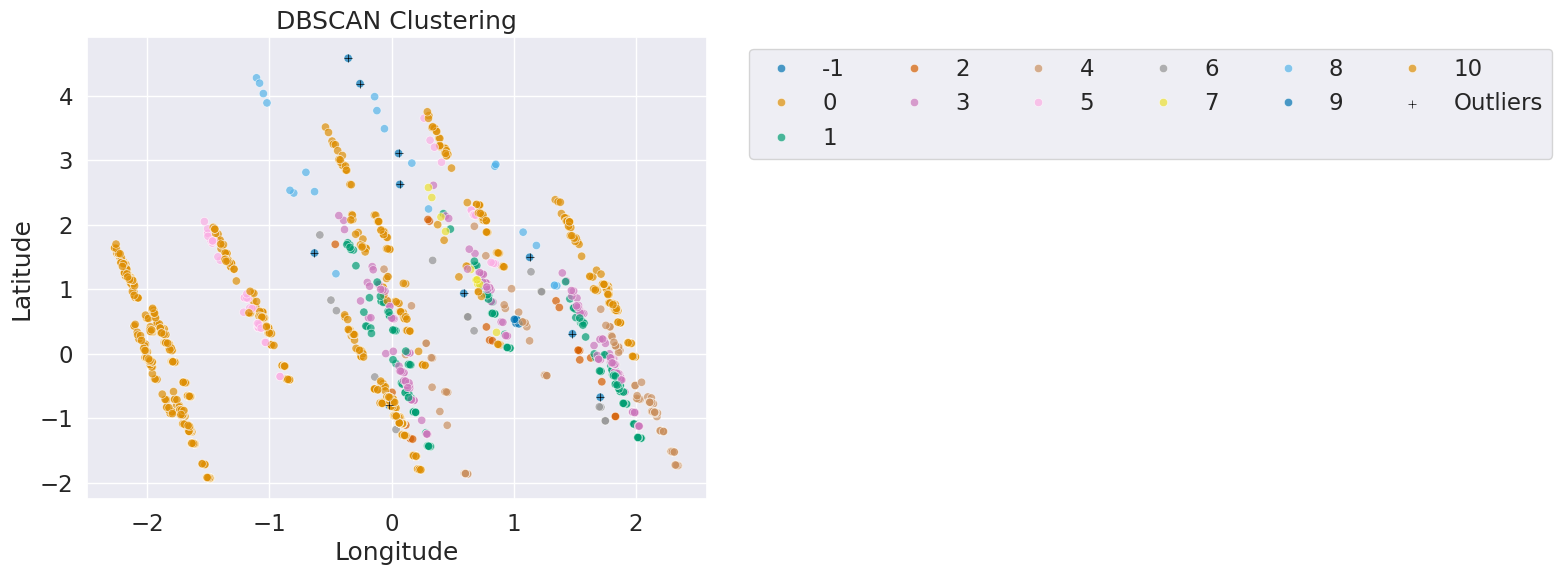

In [ ]:
plot_dbscan(df_mapped, dbscan)

In [ ]:
n_clusters_ = len(set(dbscan.labels_)) - (1 if -1 in dbscan.labels_ else 0)
n_noise_ = list(dbscan.labels_).count(-1)
total_points = len(df_mapped)
percentage_noise = (n_noise_ / total_points) * 100
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Percent of noise: %.4f" % percentage_noise, '%')


Estimated number of clusters: 11
Estimated number of noise points: 10
Percent of noise: 0.4427 %


### DBSCAN with params tuning

In [ ]:

def tune_dbscan(X, param_grid):

    dbscan = DBSCAN()

    scoring = {'silhouette': silhouette_score, 'calinski_harabasz': calinski_harabasz_score}

    sil_scores = np.zeros((len(param_grid['min_samples']), len(param_grid['eps'])))
    cal_scores = np.zeros((len(param_grid['min_samples']), len(param_grid['eps'])))

    for i, min_samples in enumerate(param_grid['min_samples']):
        dbscan.set_params(min_samples=min_samples)
        for j, eps in enumerate(param_grid['eps']):
            dbscan.set_params(eps=eps)
            dbscan.fit(X)
            sil_scores[i, j] = scoring['silhouette'](X, dbscan.labels_)
            cal_scores[i, j] = scoring['calinski_harabasz'](X, dbscan.labels_)

    best_min_samples = param_grid['min_samples'][np.argmax(np.mean(sil_scores, axis=1))]
    best_eps = param_grid['eps'][np.argmax(np.mean(sil_scores, axis=0))]

    return best_min_samples, best_eps, sil_scores, cal_scores

In [ ]:
def tune_dbscan1(X, param_grid):

    dbscan = DBSCAN()

    scoring = {'silhouette': silhouette_score, 'calinski_harabasz': calinski_harabasz_score}

    sil_scores = np.zeros((len(param_grid['min_samples']), len(param_grid['eps'])))
    cal_scores = np.zeros((len(param_grid['min_samples']), len(param_grid['eps'])))

    all_labels = []
    all_scores = []

    for i, min_samples in enumerate(param_grid['min_samples']):
        dbscan.set_params(min_samples=min_samples)
        for j, eps in enumerate(param_grid['eps']):
            dbscan.set_params(eps=eps)
            dbscan.fit(X)
            labels = dbscan.labels_
            labels_set = set(labels)
            num_clusters = len(labels_set)
            if -1 in labels_set:
                num_clusters -= 1
            if (num_clusters < 2) or (num_clusters > 6):
                all_scores.append(-20)
                all_labels.append('Poor')
                continue
            sil_scores[i, j] = scoring['silhouette'](X, labels)
            cal_scores[i, j] = scoring['calinski_harabasz'](X, labels)
            all_scores.append(sil_scores[i, j])
            all_labels.append(labels)

    best_min_samples = param_grid['min_samples'][np.argmax(np.mean(sil_scores, axis=1))]
    best_eps = param_grid['eps'][np.argmax(np.mean(sil_scores, axis=0))]

    return best_min_samples, best_eps, all_scores, all_labels

In [ ]:
params = {'min_samples':[i for i in range(5, 30, 4)],
          'eps':np.linspace(2, 5, 19)}
best_min_samples_res, best_eps_res, all_scores, all_labels = tune_dbscan1(df_mapped, params)


In [ ]:
params = {'min_samples':[i for i in range(5, 30, 4)],
          'eps':np.linspace(2, 5, 19)}
best_min_samples, best_eps, all_scores, all_labels = tune_dbscan(df_mapped, params)


In [ ]:
print("Best min_samples: %.4f" % best_min_samples)
print("Best eps: %.4f" % best_eps)

Best min_samples: 5.0000
Best eps: 3.0000


In [ ]:
print("Limited Best min_samples: %.4f" % best_min_samples_res)
print("Limited Best eps: %.4f" % best_eps_res)

Limited Best min_samples: 17.0000
Limited Best eps: 4.6667


In [ ]:
tuned_dbscan = DBSCAN(eps=best_eps, min_samples = best_min_samples)
labels = tuned_dbscan.fit_predict(df_mapped)

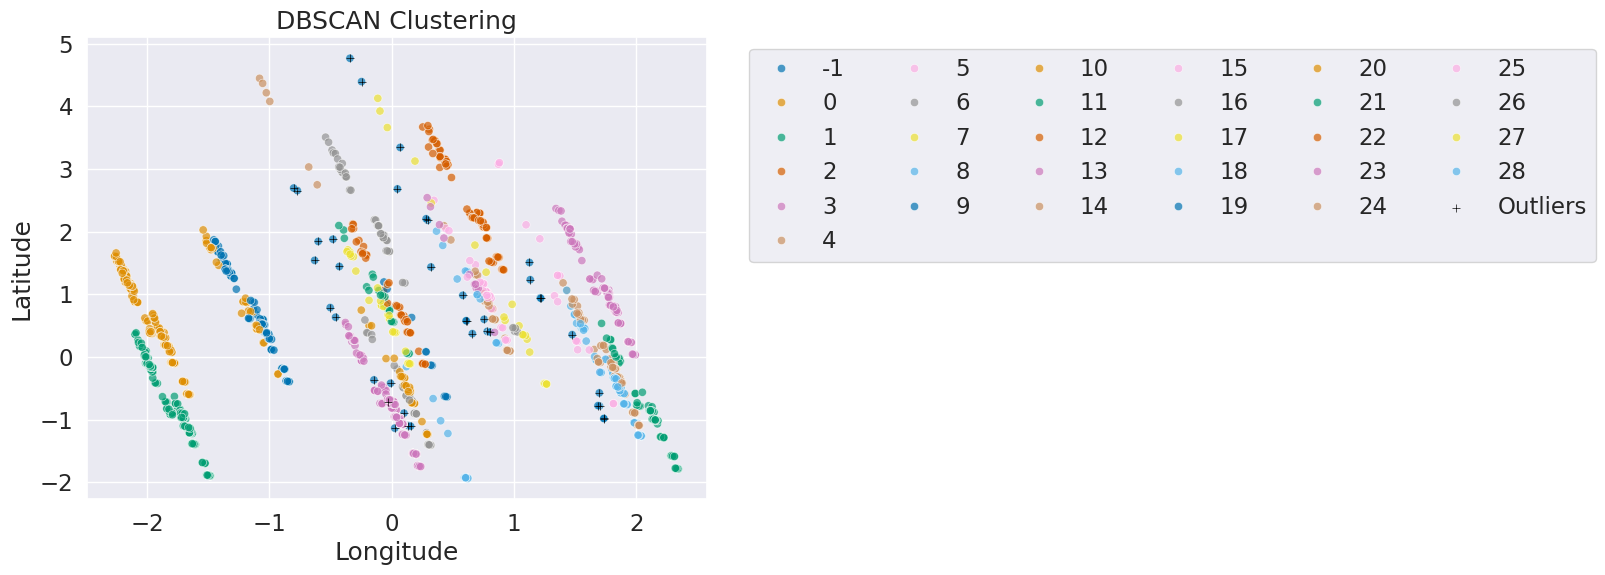

In [ ]:
plot_dbscan(df_mapped, tuned_dbscan)

In [ ]:
n_clusters_ = len(set(tuned_dbscan.labels_)) - (1 if -1 in tuned_dbscan.labels_ else 0)
n_noise_ = list(tuned_dbscan.labels_).count(-1)
total_points = len(df_mapped)
percentage_noise = (n_noise_ / total_points) * 100
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Percent of noise: %.4f" % percentage_noise, '%')

Estimated number of clusters: 29
Estimated number of noise points: 39
Percent of noise: 1.7264 %


In [ ]:
tuned_dbscan_lim = DBSCAN(eps=best_eps_res, min_samples = best_min_samples_res)
labels = tuned_dbscan_lim.fit_predict(df_mapped)

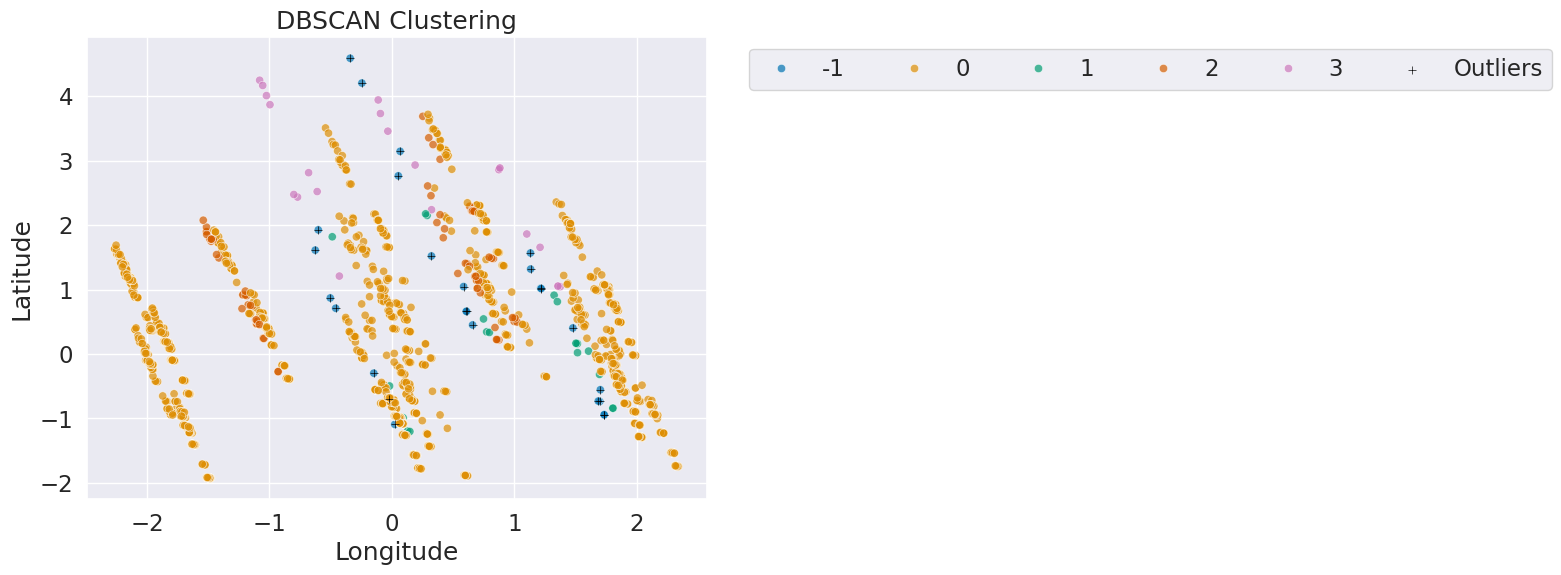

In [ ]:
plot_dbscan(df_mapped, tuned_dbscan_lim)

In [ ]:
n_clusters_ = len(set(tuned_dbscan_lim.labels_)) - (1 if -1 in tuned_dbscan_lim.labels_ else 0)
n_noise_ = list(tuned_dbscan_lim.labels_).count(-1)
total_points = len(df_mapped)
percentage_noise = (n_noise_ / total_points) * 100
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Percent of noise: %.4f" % percentage_noise, '%')

Estimated number of clusters: 4
Estimated number of noise points: 26
Percent of noise: 1.1510 %


In [ ]:
dbscan_rand = DBSCAN(eps= best_eps, min_samples= 2)
labels = dbscan_rand.fit_predict(df_mapped)

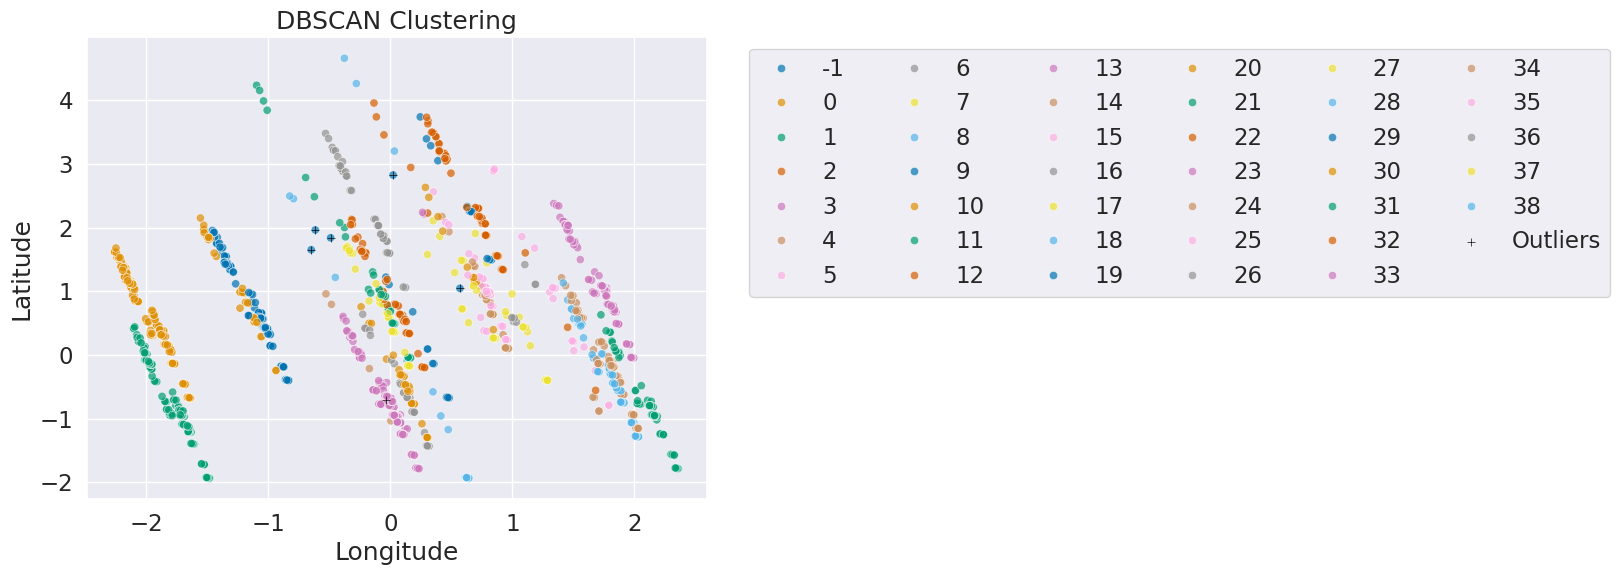

In [ ]:
plot_dbscan(df_mapped, dbscan_rand)

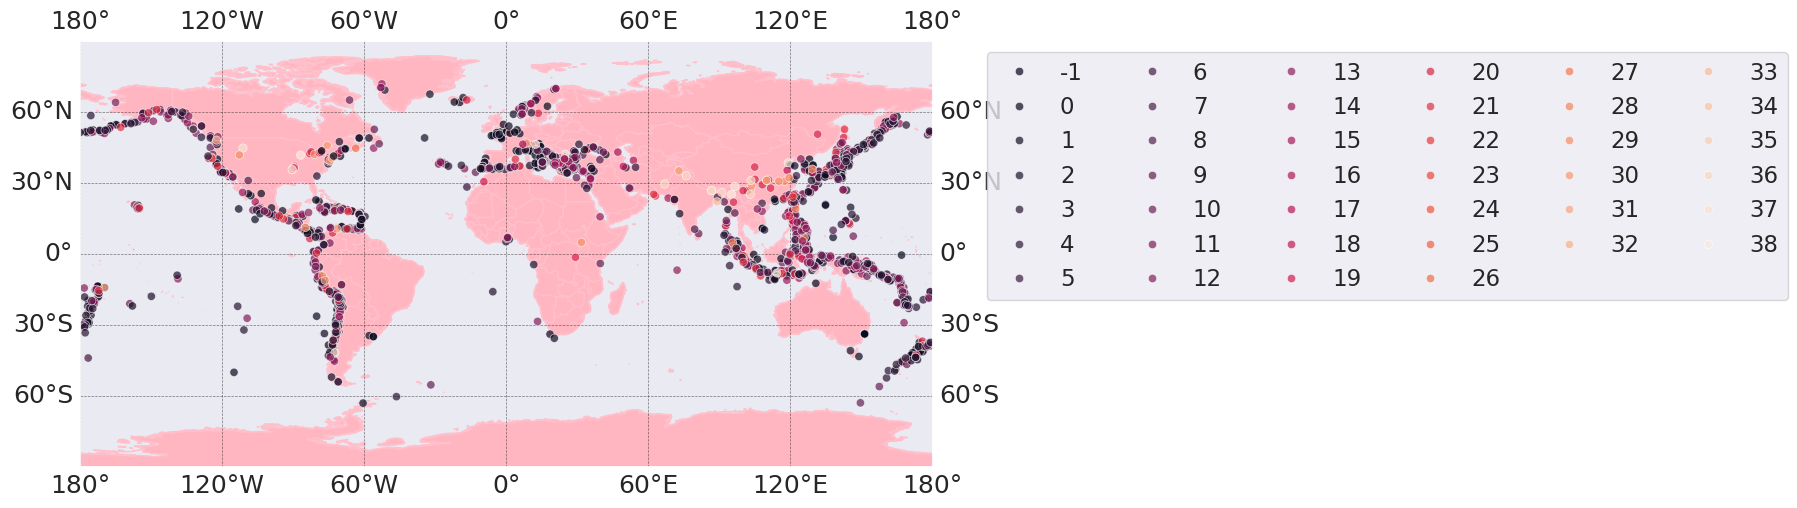

In [ ]:

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([-180, 180, -90, 90])
ax.add_feature(cfeature.LAND, facecolor='lightpink', edgecolor='pink', zorder=0)
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), edgecolor='pink', zorder=1)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), edgecolor='pink', zorder=0)

ax.gridlines(draw_labels=True, linewidth=0.5, color='black', alpha=0.5, linestyle='--')

scatter = sns.scatterplot(df, x='LONGITUDE', y='LATITUDE', hue= dbscan_rand.fit_predict(df_mapped) , legend='full', alpha=0.7, palette = "rocket", ax = ax, zorder=2)

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncols = 6)

plt.show()


In [ ]:
n_clusters_ = len(set(dbscan_rand.labels_)) - (1 if -1 in dbscan_rand.labels_ else 0)
n_noise_ = list(dbscan_rand.labels_).count(-1)
total_points = len(df_mapped)
percentage_noise = (n_noise_ / total_points) * 100
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Percent of noise: %.4f" % percentage_noise, '%')

Estimated number of clusters: 39
Estimated number of noise points: 6
Percent of noise: 0.2656 %


In [ ]:
calculate_cluster_scores(df_mapped, dbscan_rand.labels_, 'rand')

Model  Silhouette Score  Calinski-Harabasz Score
0  rand          0.476065               280.921269

## Results

In [ ]:
results = pd.concat([calculate_cluster_scores(df_mapped, kmeans2.labels_, 'kmeans 2 clasters'),
                     calculate_cluster_scores(df_mapped, kmeans.labels_, 'kmeans 4 clasters'),
                    calculate_cluster_scores(df_mapped, dbscan.labels_, 'dbscan'),
                    calculate_cluster_scores(df_mapped, tuned_dbscan.labels_, 'tuned dbscan'),
                    calculate_cluster_scores(df_mapped, dbscan_rand.labels_, 'rand'),
                    calculate_cluster_scores(df_mapped, tuned_dbscan_lim.labels_, 'tuned dbscan limited clasters')])
results

Model  Silhouette Score  Calinski-Harabasz Score
0              kmeans 2 clasters          0.196425               167.109122
0              kmeans 4 clasters          0.197292               217.689330
0                         dbscan          0.285835               207.526490
0                   tuned dbscan          0.466008               199.383292
0                           rand          0.476065               280.921269
0  tuned dbscan limited clasters          0.316960               170.942898